# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Suppress specific warnings if needed
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, message='.*Could not infer format.*')

In [26]:
# !! REPLACE with the correct path to your Excel file !!
excel_file_path = '/Users/sienkadounia/Downloads/TGA- empty fruit bunch - to Hassan (1).xlsx'

# Heating rates and corresponding sheet names (VERIFY THESE)
sheet_names = {
    10: '10°Cmin',
    20: '20°Cmin',
    50: '50°Cmin'
}
heating_rates = list(sheet_names.keys())
# Specify which rates have the header in the second row (index 1)
rates_with_header_row_2 = [20, 50, 10]  # Added 10 to this list

# --- Define Standardized Column Names ---
# We will rename the columns from each sheet to these standard names.
std_col_time = 'Time_min'
std_col_temp = 'Temperature_C'
std_col_mass = 'Mass_mg'
std_col_atg = 'ATG_percent' # <<< This is our TARGET variable
std_col_dtg_time = 'DTG_percent_per_min'
std_col_dtg_temp = 'DTG_percent_per_C'

# The columns we absolutely NEED for the model (using standard names)
required_std_cols = [std_col_temp, std_col_atg]
# Features we will use for modeling X = f(T, Rate) -> ATG (using standard names)
feature_std_cols = [std_col_temp, 'Heating_Rate']

In [27]:
# --- Data Loading, Renaming, and Combination ---

all_data_list = []
print("Loading, renaming, and combining data from sheets...")

for rate in heating_rates:
    sheet = sheet_names.get(rate)
    if not sheet:
        print(f"Warning: No sheet name defined for heating rate {rate}. Skipping.")
        continue

    print(f"\n--- Processing Sheet: {sheet} (Heating Rate: {rate}°C/min) ---")
    try:
        # --- Set header row based on heating rate ---
        header_row_index = 0 # Default: first row is header
        if rate in rates_with_header_row_2:
            header_row_index = 1 # Use second row as header for rates 20 and 50
            print(f"  Note: Reading sheet '{sheet}' with header from row {header_row_index + 1} (skipping first row).")
        else:
            # This executes for rate == 10
            print(f"  Note: Reading sheet '{sheet}' with header from row {header_row_index + 1}.")

        # Load the raw TGA data using the determined header row
        df_raw = pd.read_excel(excel_file_path, sheet_name=sheet, header=header_row_index)
        # --- DEBUG: Print columns immediately after loading ---
        print(f"  DEBUG: Columns as read by pandas: {df_raw.columns.tolist()}")

        # Strip leading/trailing whitespace from column names robustly
        original_columns_stripped = [str(col).strip() for col in df_raw.columns]
        df_raw.columns = original_columns_stripped
        print(f"  DEBUG: Columns after stripping whitespace: {original_columns_stripped}")


        # --- Define Renaming Map based on Rate ---
        # Use the stripped column names as keys in the map definitions
        rename_map = {}
        if rate == 10:
            # Based on user input: 't (min)', 'T (°C)', 'm (mg)', 'ATG (%)', 'Deriv, Weight (%/min)', 'Deriv, Weight (%/°C)'
            # !! VERIFY THESE KEYS EXACTLY MATCH the stripped names printed above !!
            rename_map = {
                't (min)': std_col_time,
                'T (°C)': std_col_temp,
                'm (m)g': std_col_mass,          # WATCH OUT for potential hidden spaces or exact parenthesis `m (mg)` vs `m(mg)`
                'ATG (%)': std_col_atg,
                'Deriv, Weight (%/min)': std_col_dtg_time, # WATCH OUT for comma vs period, space
                'Deriv, Weight (%/°C)': std_col_dtg_temp
            }
            print("  DEBUG: Defined rename_map for rate 10.")

        elif rate == 20:
            # Based on user input: 't', 'T', 'mg', 'ATG (%)', 'DTG (%/min)', 'DTG (%/°C)'
            rename_map = {
                't': std_col_time,
                'T': std_col_temp,
                'mg': std_col_mass,
                'ATG (%)': std_col_atg,
                'DTG (%/min)': std_col_dtg_time,
                'DTG (%/°C)': std_col_dtg_temp
            }
            print("  DEBUG: Defined rename_map for rate 20.")

        elif rate == 50:
            # Based on user input: 'Time (min)', 'Temperature (°C)', 'Weight (mg)', 'ATG (%)', 'DTG (%/min)', 'DTG (%/°C)'
            rename_map = {
                'Time (min)': std_col_time,
                'Temperature (°C)': std_col_temp,
                'Weight (mg)': std_col_mass,
                'ATG (%)': std_col_atg,
                'DTG (%/min)': std_col_dtg_time,
                'DTG (%/°C)': std_col_dtg_temp
            }
            print("  DEBUG: Defined rename_map for rate 50.")

        # --- Apply Renaming ---
        # Create the actual map based on columns that *exist* after stripping
        rename_actual = {k: v for k, v in rename_map.items() if k in original_columns_stripped}
        # --- DEBUG: Print the rename map being used ---
        print(f"  DEBUG: Actual rename map being applied: {rename_actual}")

        df_raw.rename(columns=rename_actual, inplace=True)
        renamed_columns = df_raw.columns.tolist()
        print(f"  Renamed columns: {renamed_columns}")

        # --- Check if Required Standard Columns Exist After Renaming ---
        missing_std = [col for col in required_std_cols if col not in renamed_columns]
        if missing_std:
            print(f"  Error: Missing required standardized columns after renaming: {missing_std}. Check original column names and renaming map. Skipping sheet.")
            # --- DEBUG: Print DataFrame columns when error occurs ---
            print(f"  DEBUG: Columns present when error occurred: {renamed_columns}")
            continue # Skip this sheet

        # --- Select only the columns with standard names that we defined ---
        # Include all standardized columns that were successfully renamed/present
        available_std_cols = [
            std_col_time, std_col_temp, std_col_mass, std_col_atg,
            std_col_dtg_time, std_col_dtg_temp
        ]
        cols_to_keep = [col for col in available_std_cols if col in renamed_columns]
        df_sheet = df_raw[cols_to_keep].copy()

        # Add Heating_Rate column
        df_sheet['Heating_Rate'] = rate

        # --- Convert relevant columns to numeric ---
        # Use standard names here
        numeric_cols = [std_col_temp, std_col_atg, std_col_mass, std_col_dtg_time, std_col_dtg_temp, std_col_time]
        print(f"  DEBUG: Attempting numeric conversion for columns: {numeric_cols}")
        for col in numeric_cols:
            if col in df_sheet.columns:
                original_dtype = df_sheet[col].dtype
                df_sheet[col] = pd.to_numeric(df_sheet[col], errors='coerce')
                if df_sheet[col].isnull().any() and not pd.isna(original_dtype): # Check if NaNs were introduced
                    print(f"    Warning: Coerced non-numeric values to NaN in column '{col}'.")


        # --- Drop rows where essential columns became NaN ---
        initial_rows = len(df_sheet)
        # Use standard names here
        df_sheet.dropna(subset=required_std_cols, inplace=True)
        rows_dropped = initial_rows - len(df_sheet)
        if rows_dropped > 0:
            print(f"  Dropped {rows_dropped} rows due to NaN values in essential columns {required_std_cols} after numeric conversion.")

        if df_sheet.empty:
            print(f"  Warning: No valid data rows remain in sheet '{sheet}' after cleaning NaNs in essential columns.")
            continue

        # --- DEBUG: Print info after cleaning ---
        print(f"  DEBUG: Data shape after cleaning for rate {rate}: {df_sheet.shape}")
        # print(f"  DEBUG: Head of cleaned data for rate {rate}:\n{df_sheet.head()}") # Uncomment for more detail

        print(f"  Sheet '{sheet}' processed successfully.")
        all_data_list.append(df_sheet)

    except FileNotFoundError:
        print(f"Error: File not found at {excel_file_path}")
        break # Stop processing if file not found
    except Exception as e:
        print(f"Error processing sheet '{sheet}': {e}")
        import traceback
        traceback.print_exc() # Print full error traceback for debugging

Loading, renaming, and combining data from sheets...

--- Processing Sheet: 10°Cmin (Heating Rate: 10°C/min) ---
  Note: Reading sheet '10°Cmin' with header from row 2 (skipping first row).
  DEBUG: Columns as read by pandas: ['t (min)', 'T (°C)', 'm  (m)g', 'ATG (%)', 'Deriv, Weight (%/min)', 'Deriv, Weight (%/°C)']
  DEBUG: Columns after stripping whitespace: ['t (min)', 'T (°C)', 'm  (m)g', 'ATG (%)', 'Deriv, Weight (%/min)', 'Deriv, Weight (%/°C)']
  DEBUG: Defined rename_map for rate 10.
  DEBUG: Actual rename map being applied: {'t (min)': 'Time_min', 'T (°C)': 'Temperature_C', 'ATG (%)': 'ATG_percent', 'Deriv, Weight (%/min)': 'DTG_percent_per_min', 'Deriv, Weight (%/°C)': 'DTG_percent_per_C'}
  Renamed columns: ['Time_min', 'Temperature_C', 'm  (m)g', 'ATG_percent', 'DTG_percent_per_min', 'DTG_percent_per_C']
  DEBUG: Attempting numeric conversion for columns: ['Temperature_C', 'ATG_percent', 'Mass_mg', 'DTG_percent_per_min', 'DTG_percent_per_C', 'Time_min']
  DEBUG: Data shape

In [29]:
# --- Combine data from all sheets into a single DataFrame ---
if not all_data_list:
    print("\nError: No data successfully loaded and processed from any sheet. Cannot proceed.")
    exit() # Stop script
else:
    all_data = pd.concat(all_data_list, ignore_index=True)
    print("\n----------------------------------------")
    print("Data Loading and Preparation Complete.")
    print("Combined DataFrame Info:")
    all_data.info() # Uses standard names now
    print("\nCombined DataFrame Head:\n", all_data.head())
    print("\nCombined DataFrame Description:\n", all_data.describe())
    print("\nMissing values check in final combined data:")
    print(all_data.isnull().sum())


----------------------------------------
Data Loading and Preparation Complete.
Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11635 entries, 0 to 11634
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time_min             11635 non-null  float64
 1   Temperature_C        11635 non-null  float64
 2   ATG_percent          11635 non-null  float64
 3   DTG_percent_per_min  11635 non-null  float64
 4   DTG_percent_per_C    11635 non-null  float64
 5   Heating_Rate         11635 non-null  int64  
 6   Mass_mg              4810 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 636.4 KB

Combined DataFrame Head:
    Time_min  Temperature_C  ATG_percent  DTG_percent_per_min  \
0  0.002367       31.22764    99.992671             0.802634   
1  0.004167       31.23835    99.988286             0.799979   
2  0.012500       31.25094    99.984349             0.798801   
3


----------------------------------------
Starting Basic Exploratory Data Analysis (EDA)...

Generating ATG vs Temperature plot...


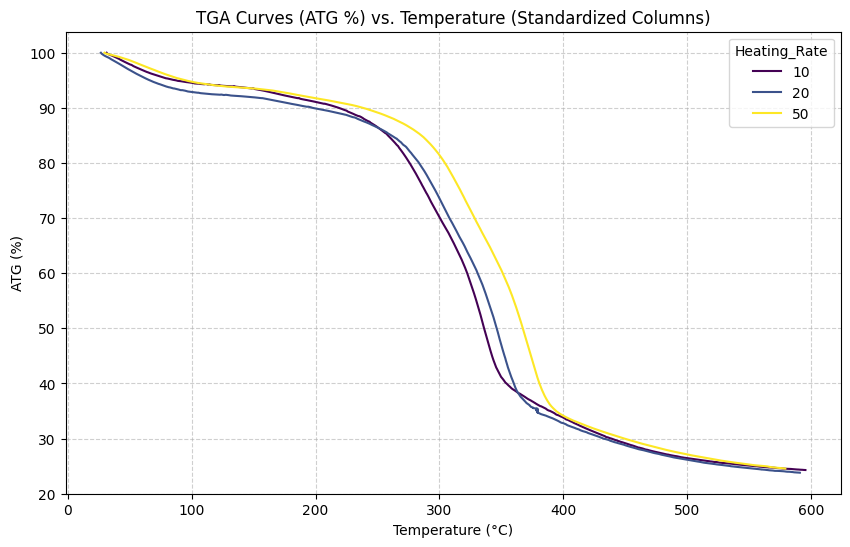


Checking distribution of data points by Heating Rate...


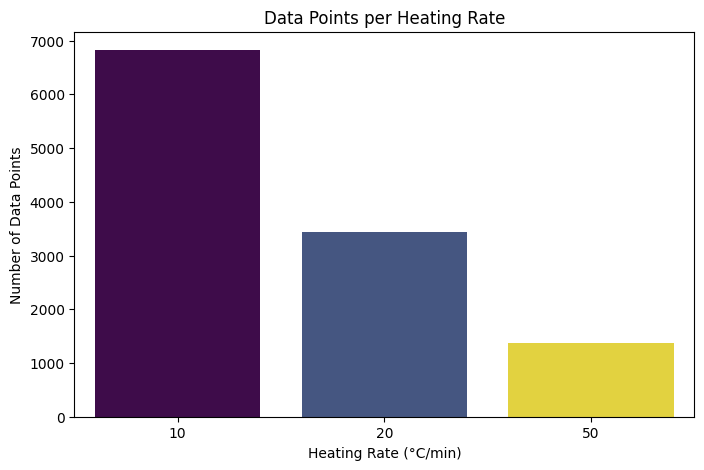


End of Phase 1: Data Loading & Preparation.
----------------------------------------


In [31]:
# --- Basic EDA on Combined Data ---
# (This part remains the same as before, using standard column names like std_col_temp, std_col_atg)
if 'all_data' in locals() and not all_data.empty:
    print("\n----------------------------------------")
    print("Starting Basic Exploratory Data Analysis (EDA)...")

    # Plot ATG vs Temperature, colored by Heating Rate
    print("\nGenerating ATG vs Temperature plot...")
    try:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=all_data, x=std_col_temp, y=std_col_atg, hue='Heating_Rate', palette='viridis', legend='full')
        plt.title('TGA Curves (ATG %) vs. Temperature (Standardized Columns)')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('ATG (%)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    except Exception as e:
        print(f"Error generating ATG vs Temp plot: {e}")

    # Distribution of Heating Rates in the combined data
    print("\nChecking distribution of data points by Heating Rate...")
    try:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=all_data, x='Heating_Rate', palette='viridis', hue='Heating_Rate', legend=False)
        plt.title('Data Points per Heating Rate')
        plt.xlabel('Heating Rate (°C/min)')
        plt.ylabel('Number of Data Points')
        plt.show()
    except Exception as e:
        print(f"Error generating count plot: {e}")
else:
    print("\nSkipping EDA: 'all_data' DataFrame is not available or empty.")


print("\nEnd of Phase 1: Data Loading & Preparation.")
print("----------------------------------------")

In [10]:
all_data.describe()

,Time_min,Temperature_C,ATG_percent,DTG_percent_per_min,DTG_percent_per_C,Heating_Rate,Mass_mg
count,11635.000000,11635.000000,11635.000000,11635.000000,11635.000000,11635.000000,4810.000000
mean,21.584301,307.230809,62.249824,2.344472,0.134013,17.663945,3.665937
std,15.888360,164.373011,29.957549,4.143921,0.170718,12.613950,1.782027
min,0.000900,26.595050,23.807714,-0.395842,0.008363,10.000000,1.290140
25%,8.070832,164.544050,29.175292,0.474532,0.034761,10.000000,1.719256
50%,18.529170,306.815800,69.628741,0.961142,0.068601,10.000000,4.304214
75%,32.625000,449.687950,92.212041,2.250414,0.127536,20.000000,5.039918
max,56.862500,595.554000,99.996700,38.586790,0.815267,50.000000,6.605782


# Modeling and Training

In [32]:
# Continue in the same script or ensure 'all_data' DataFrame is available
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression # Basic linear likely too simple for curve shape
from sklearn.svm import SVR # May work but can be slow on large data
from sklearn.preprocessing import StandardScaler # Good practice for some models
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


Starting Phase 2 & 3: Model Building, Extrapolation & Confidence Intervals
----------------------------------------

Using features: ['Temperature_C', 'Heating_Rate']
Target variable: ATG_percent
Shape of X: (11635, 2), Shape of y: (11635,)

Data split:
  Training set size:   8144
  Validation set size: 1745
  Test set size:       1746

Heating Rate distribution in sets:
  Train: [   0 4777 2409    0    0  958]
  Val:   [   0 1024  516    0    0  205]
  Test:  [   0 1024  516    0    0  206]

--- Hyperparameter Tuning (Example: Random Forest) ---
Starting GridSearchCV for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


Best parameters found: {'rf__max_depth': 20, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}

Best RF Model Validation Performance: RMSE=0.1365, R2=1.0000

--- Training Final Model on Train+Validation Data ---
Final model trained.

--- Final Model Performance on Test Set ---
RMSE: 0.0619
MAE:  0.0238
R²:   1.0000

--- Visualizing Test Set Predictions ---


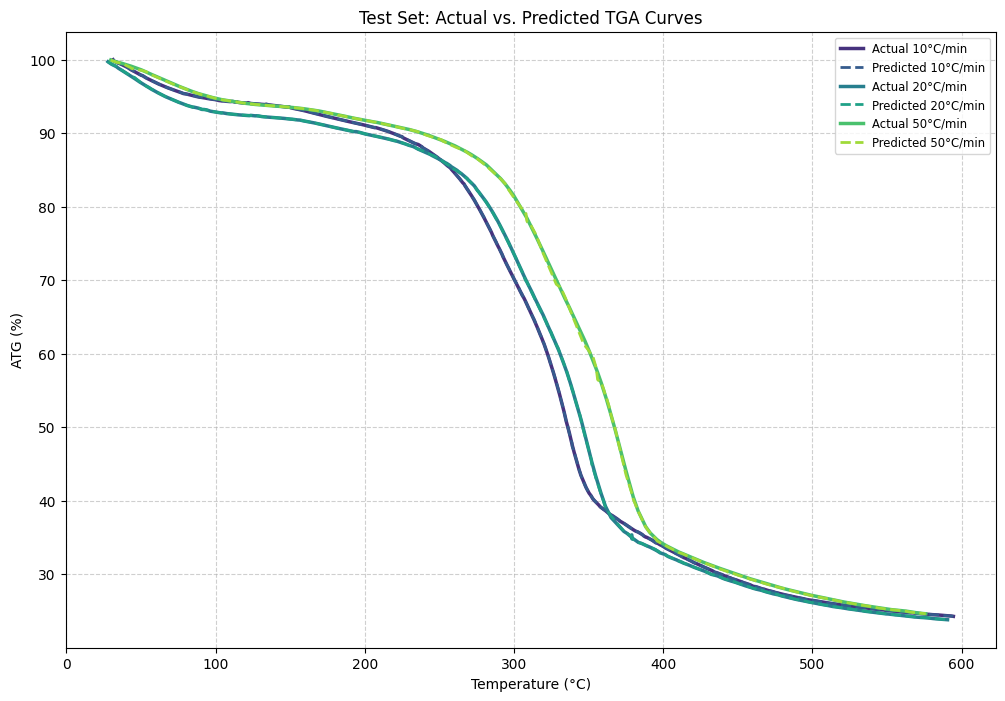


--- Extrapolating ATG (%) for unseen heating rates: [30, 40, 60] ---
Created extrapolation input data with 600 points.

--- Visualizing Extrapolated TGA Curves ---


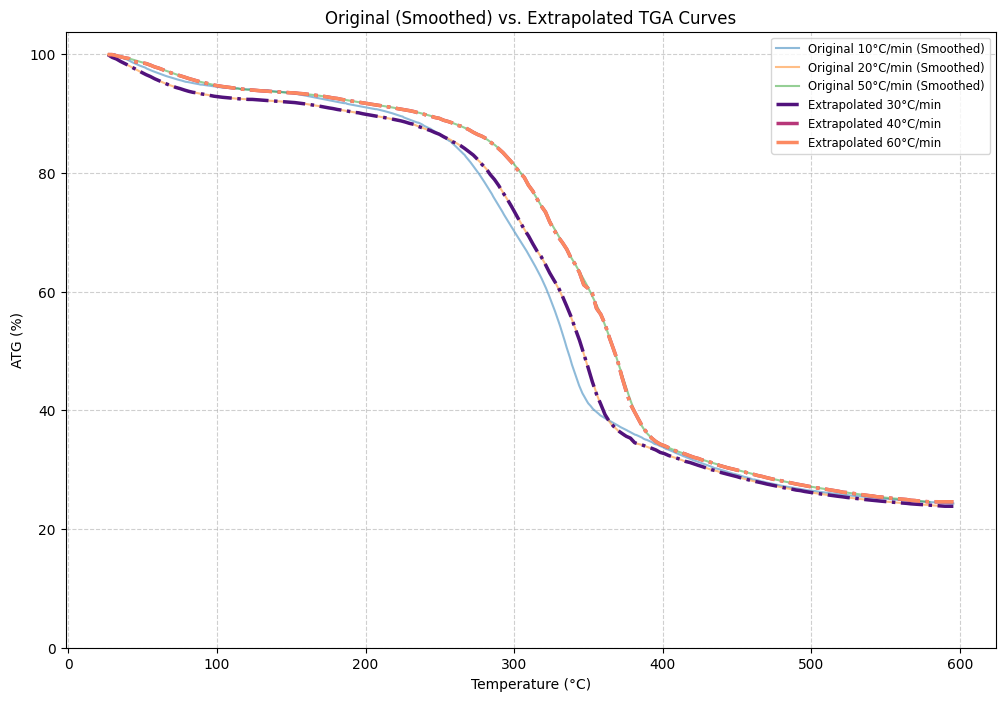


--- Generating 100 bootstrap predictions for unseen rates ---
  Completed bootstrap sample 20/100
  Completed bootstrap sample 40/100
  Completed bootstrap sample 60/100
  Completed bootstrap sample 80/100
  Completed bootstrap sample 100/100

Calculating 95% Confidence Intervals for extrapolations...

--- Visualizing Extrapolated Curves with 95% CIs ---


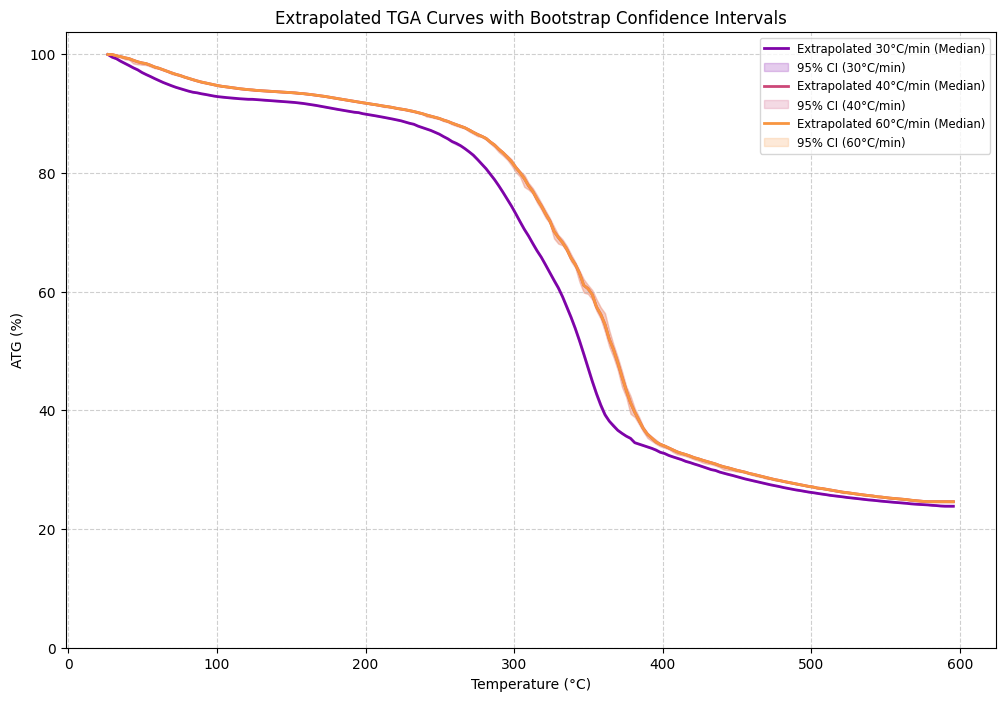


End of Phase 2 & 3: Modeling, Extrapolation & Confidence Intervals.
----------------------------------------


In [33]:
print("\nStarting Phase 2 & 3: Model Building, Extrapolation & Confidence Intervals")
print("----------------------------------------")

# --- Check if all_data is ready from Phase 1 ---
if 'all_data' in locals() and isinstance(all_data, pd.DataFrame) and not all_data.empty:

    # Define features (X) and target (y) based on our refined choice
    feature_cols = [temp_col, 'Heating_Rate'] # Inputs: Temperature and Heating Rate
    target_col = target_col # Output: ATG (%)

    if not all(col in all_data.columns for col in feature_cols):
         print(f"\nError: Missing required feature columns {feature_cols} in the data. Cannot proceed.")
    elif target_col not in all_data.columns:
         print(f"\nError: Missing target column {target_col} in the data. Cannot proceed.")
    else:
        X = all_data[feature_cols]
        y = all_data[target_col]

        print(f"\nUsing features: {feature_cols}")
        print(f"Target variable: {target_col}")
        print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

        # --- Data Splitting ---
        # Stratify by Heating_Rate to ensure all rates are represented in train/test/val
        # Split ratio: e.g., 70% train, 15% validation, 15% test
        try:
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=X['Heating_Rate']
            )
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42, stratify=X_temp['Heating_Rate']
            )

            print(f"\nData split:")
            print(f"  Training set size:   {X_train.shape[0]}")
            print(f"  Validation set size: {X_val.shape[0]}")
            print(f"  Test set size:       {X_test.shape[0]}")

            # Check distribution of Heating Rates in splits
            print("\nHeating Rate distribution in sets:")
            print("  Train:", np.bincount(X_train['Heating_Rate'].astype(int))[::10]) # Rough check
            print("  Val:  ", np.bincount(X_val['Heating_Rate'].astype(int))[::10])
            print("  Test: ", np.bincount(X_test['Heating_Rate'].astype(int))[::10])

        except Exception as e:
             print(f"\nError during data splitting (maybe too few samples for stratification?): {e}")
             print("Attempting simple random split instead...")
             X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
             X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
             print(f"  Using simple split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")


        # --- Model Selection and Training ---
        # Tree-based models often work well for this type of task.
        
        # Define models (Using Pipelines for potential scaling later if needed)
        # RandomForestRegressor is a good default choice
        pipe_rf = Pipeline([
             # ('scaler', StandardScaler()), # Optional for RF
             ('rf', RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1,
                                          max_depth=20, # Limit depth slightly to prevent extreme overfitting
                                          min_samples_split=10, # Require more samples to split
                                          min_samples_leaf=5 # Require more samples per leaf
                                          ))
        ])

        # GradientBoostingRegressor is another strong option
        pipe_gbr = Pipeline([
             # ('scaler', StandardScaler()), # Optional for GBR
             ('gbr', GradientBoostingRegressor(random_state=42, n_estimators=100,
                                               learning_rate=0.1, max_depth=5)) # Common starting point
        ])


        # --- Hyperparameter Tuning (Optional but Recommended) ---
        # Example using GridSearchCV on Random Forest with the Validation set
        print("\n--- Hyperparameter Tuning (Example: Random Forest) ---")
        # Define parameter grid (adjust ranges based on initial results/data size)
        param_grid_rf = {
            'rf__n_estimators': [50, 100], # Fewer trees might be okay
            'rf__max_depth': [10, 20, None],
            'rf__min_samples_split': [10, 20],
            'rf__min_samples_leaf': [5, 10]
        }

        # Use a smaller subset for faster grid search if needed
        # X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42, stratify=X_train['Heating_Rate'])

        # Grid search using validation set implicitly (by fitting on train, scoring is implied on folds)
        # Set cv=3 or 5 for cross-validation within the training set
        grid_search_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_rf,
                                     cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

        try:
            print("Starting GridSearchCV for Random Forest...")
            grid_search_rf.fit(X_train, y_train) # Fit on the full training set
            print("Best parameters found:", grid_search_rf.best_params_)
            best_rf_model = grid_search_rf.best_estimator_

            # Evaluate the best model on the validation set
            y_pred_val_rf = best_rf_model.predict(X_val)
            rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_pred_val_rf))
            r2_val_rf = r2_score(y_val, y_pred_val_rf)
            print(f"\nBest RF Model Validation Performance: RMSE={rmse_val_rf:.4f}, R2={r2_val_rf:.4f}")

            # Train final model (potentially chosen one like RF) on Train+Validation data
            print("\n--- Training Final Model on Train+Validation Data ---")
            # Combine train and validation sets
            X_train_val = pd.concat([X_train, X_val])
            y_train_val = pd.concat([y_train, y_val])
            final_model = clone(best_rf_model) # Use the best estimator structure
            final_model.fit(X_train_val, y_train_val)
            print("Final model trained.")

            # Evaluate final model on the unseen Test set
            y_pred_test = final_model.predict(X_test)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            mae_test = mean_absolute_error(y_test, y_pred_test)
            r2_test = r2_score(y_test, y_pred_test)
            print("\n--- Final Model Performance on Test Set ---")
            print(f"RMSE: {rmse_test:.4f}")
            print(f"MAE:  {mae_test:.4f}")
            print(f"R²:   {r2_test:.4f}")

            # --- Visualize Predictions vs Actual on Test Set ---
            print("\n--- Visualizing Test Set Predictions ---")
            plt.figure(figsize=(12, 8))
            test_results = X_test.copy()
            test_results['Actual_ATG'] = y_test
            test_results['Predicted_ATG'] = y_pred_test

            # Plot curves for each heating rate in the test set
            unique_test_rates = sorted(test_results['Heating_Rate'].unique())
            palette = sns.color_palette('viridis', n_colors=len(unique_test_rates) * 2) # Different shade for pred/actual

            for i, rate in enumerate(unique_test_rates):
                rate_data = test_results[test_results['Heating_Rate'] == rate].sort_values(by=temp_col)
                plt.plot(rate_data[temp_col], rate_data['Actual_ATG'], label=f'Actual {rate}°C/min', color=palette[i*2], lw=2.5)
                plt.plot(rate_data[temp_col], rate_data['Predicted_ATG'], label=f'Predicted {rate}°C/min', color=palette[i*2+1], linestyle='--', lw=2)

            plt.title('Test Set: Actual vs. Predicted TGA Curves')
            plt.xlabel('Temperature (°C)')
            plt.ylabel('ATG (%)')
            plt.legend(fontsize='small')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()


            # --- Extrapolation to Unseen Heating Rates ---
            unseen_rates = [30, 40, 60] # Rates to predict for
            print(f"\n--- Extrapolating ATG (%) for unseen heating rates: {unseen_rates} ---")

            # Define temperature range for prediction curves
            # Use the min/max temperature observed across all original data
            temp_range = np.linspace(all_data[temp_col].min(), all_data[temp_col].max(), num=200) # 200 points for smooth curve

            X_unseen_list = []
            for rate_new in unseen_rates:
                df_rate_new = pd.DataFrame({
                    temp_col: temp_range,
                    'Heating_Rate': rate_new
                })
                X_unseen_list.append(df_rate_new)

            X_unseen = pd.concat(X_unseen_list)
            print(f"Created extrapolation input data with {len(X_unseen)} points.")

            # Predict using the final model
            predictions_unseen = final_model.predict(X_unseen[feature_cols]) # Ensure column order
            X_unseen['Predicted_ATG'] = predictions_unseen


            # --- Visualize Extrapolated Curves ---
            print("\n--- Visualizing Extrapolated TGA Curves ---")
            plt.figure(figsize=(12, 8))
            palette_unseen = sns.color_palette('magma', n_colors=len(unseen_rates))
            # Optionally plot original data means for comparison
            for i, rate in enumerate(sorted(all_data['Heating_Rate'].unique())):
                 rate_data = all_data[all_data['Heating_Rate'] == rate].sort_values(by=temp_col)
                 # Use rolling average for smoother plotting of noisy raw data
                 rate_data['ATG_smooth'] = rate_data[target_col].rolling(window=5, center=True, min_periods=1).mean()
                 plt.plot(rate_data[temp_col], rate_data['ATG_smooth'], label=f'Original {rate}°C/min (Smoothed)', alpha=0.5, lw=1.5)


            # Plot extrapolated curves
            for i, rate in enumerate(unseen_rates):
                rate_data = X_unseen[X_unseen['Heating_Rate'] == rate]
                plt.plot(rate_data[temp_col], rate_data['Predicted_ATG'], label=f'Extrapolated {rate}°C/min', color=palette_unseen[i], linestyle='-.', lw=2.5)

            plt.title('Original (Smoothed) vs. Extrapolated TGA Curves')
            plt.xlabel('Temperature (°C)')
            plt.ylabel('ATG (%)')
            plt.legend(fontsize='small')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.ylim(bottom=min(0, all_data[target_col].min() - 5)) # Adjust y-axis limits
            plt.show()


            # --- Confidence Intervals for Extrapolation (via Bootstrapping) ---
            n_bootstraps = 100 # Fewer might be okay for faster check, increase for paper (e.g., 200-500)
            print(f"\n--- Generating {n_bootstraps} bootstrap predictions for unseen rates ---")
            # We need predictions for each point in X_unseen
            bootstrap_preds_matrix = np.zeros((X_unseen.shape[0], n_bootstraps)) * np.nan

            original_indices = X_train_val.index # Use indices from combined train+val data

            for i in range(n_bootstraps):
                boot_indices = np.random.choice(original_indices, size=len(original_indices), replace=True)
                X_boot = X_train_val.loc[boot_indices]
                y_boot = y_train_val.loc[boot_indices]

                try:
                    # Clone the final model structure
                    boot_model = clone(final_model)
                     # Set random state if model allows (e.g., for RF's internal randomness)
                    if 'random_state' in boot_model.get_params():
                        boot_model.set_params(random_state=i)
                    elif isinstance(boot_model, Pipeline) and 'random_state' in boot_model.steps[-1][1].get_params():
                         final_step_name = boot_model.steps[-1][0]
                         boot_model.set_params(**{f'{final_step_name}__random_state': i})

                    boot_model.fit(X_boot, y_boot)
                    bootstrap_preds_matrix[:, i] = boot_model.predict(X_unseen[feature_cols])
                except Exception as e:
                    print(f"Warning: Bootstrap iteration {i+1} failed: {e}") # Keep NaNs

                if (i + 1) % 20 == 0: print(f"  Completed bootstrap sample {i + 1}/{n_bootstraps}")

            # Calculate CIs for unseen predictions
            print("\nCalculating 95% Confidence Intervals for extrapolations...")
            with warnings.catch_warnings(): # Suppress warnings from all-NaN slices if bootstrap failed often
                warnings.simplefilter("ignore", category=RuntimeWarning)
                lower_ci = np.nanpercentile(bootstrap_preds_matrix, 2.5, axis=1)
                upper_ci = np.nanpercentile(bootstrap_preds_matrix, 97.5, axis=1)
                median_ci = np.nanpercentile(bootstrap_preds_matrix, 50, axis=1) # Median prediction from bootstrap

            X_unseen['Pred_ATG_LowerCI'] = lower_ci
            X_unseen['Pred_ATG_UpperCI'] = upper_ci
            X_unseen['Pred_ATG_Median'] = median_ci


            # --- Visualize Extrapolated Curves with Confidence Intervals ---
            print("\n--- Visualizing Extrapolated Curves with 95% CIs ---")
            plt.figure(figsize=(12, 8))
            palette_unseen_ci = sns.color_palette('plasma', n_colors=len(unseen_rates))

            for i, rate in enumerate(unseen_rates):
                rate_data = X_unseen[X_unseen['Heating_Rate'] == rate]
                # Plot median prediction
                plt.plot(rate_data[temp_col], rate_data['Pred_ATG_Median'], color=palette_unseen_ci[i], lw=2, label=f'Extrapolated {rate}°C/min (Median)')
                # Add shaded confidence interval
                plt.fill_between(rate_data[temp_col], rate_data['Pred_ATG_LowerCI'], rate_data['Pred_ATG_UpperCI'], color=palette_unseen_ci[i], alpha=0.2, label=f'95% CI ({rate}°C/min)')

            plt.title('Extrapolated TGA Curves with Bootstrap Confidence Intervals')
            plt.xlabel('Temperature (°C)')
            plt.ylabel('ATG (%)')
            # Combine labels for clarity if too many lines
            handles, labels = plt.gca().get_legend_handles_labels()
            unique_labels = {}
            for handle, label in zip(handles, labels):
                 if "95% CI" not in label: # Keep median line labels
                      unique_labels[label] = handle
                 elif "95% CI" in label and f"95% CI ({label.split('(')[-1]}" not in unique_labels : # Keep only one CI label per rate
                      unique_labels[f"95% CI ({label.split('(')[-1]}"] = handle # Simplified label
            plt.legend(unique_labels.values(), unique_labels.keys(), fontsize='small')

            plt.grid(True, linestyle='--', alpha=0.6)
            plt.ylim(bottom=min(0, all_data[target_col].min() - 5))
            plt.show()

        except NameError as e:
            print(f"\nError: A variable needed for modeling/evaluation was not defined (likely due to errors in previous steps): {e}")
        except Exception as e:
            print(f"\nAn unexpected error occurred during modeling/evaluation: {e}")
            import traceback
            traceback.print_exc() # Print detailed traceback for debugging


else:
    print("\nModeling skipped. 'all_data' DataFrame not available or suitable from Phase 1.")

print("\nEnd of Phase 2 & 3: Modeling, Extrapolation & Confidence Intervals.")
print("----------------------------------------")

# Training


Starting Phase 2 & 3: Model Building, Extrapolation & Confidence Intervals
----------------------------------------

Using features: ['Temperature_C', 'Heating_Rate']
Target variable: ATG_percent
Shape of X: (11635, 2), Shape of y: (11635,)

Data split:
  Training set size:   8144
  Validation set size: 1745
  Test set size:       1746

Heating Rate distribution in sets:
  Train: [   0 4777 2409    0    0  958]
  Val:   [   0 1024  516    0    0  205]
  Test:  [   0 1024  516    0    0  206]

--- Hyperparameter Tuning (Example: Random Forest) ---
Starting GridSearchCV for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found: {'rf__max_depth': None, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}

Best RF Model Validation Performance: RMSE=0.1365, R2=1.0000

--- Training Final Model on Train+Validation Data ---
Final model trained.

--- Final Model Performance on Test Set ---
RMSE: 0.0619
MAE:  0.0238
R²:   

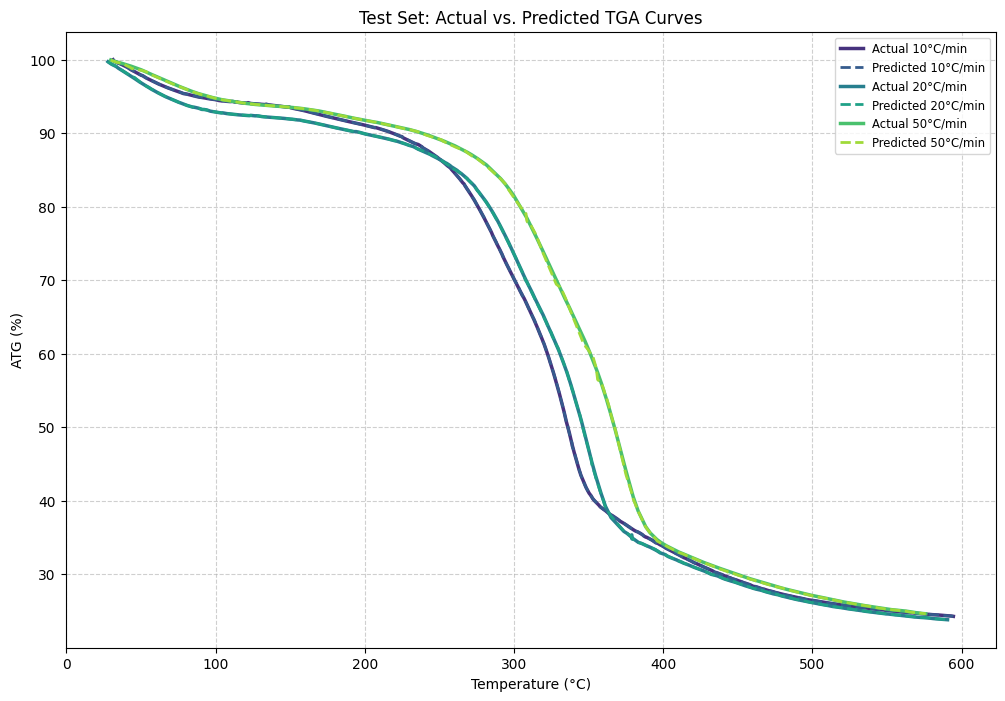


--- Extrapolating ATG (%) for unseen heating rates: [30, 40, 60] ---
Created extrapolation input data with 600 points.

--- Visualizing Extrapolated TGA Curves ---


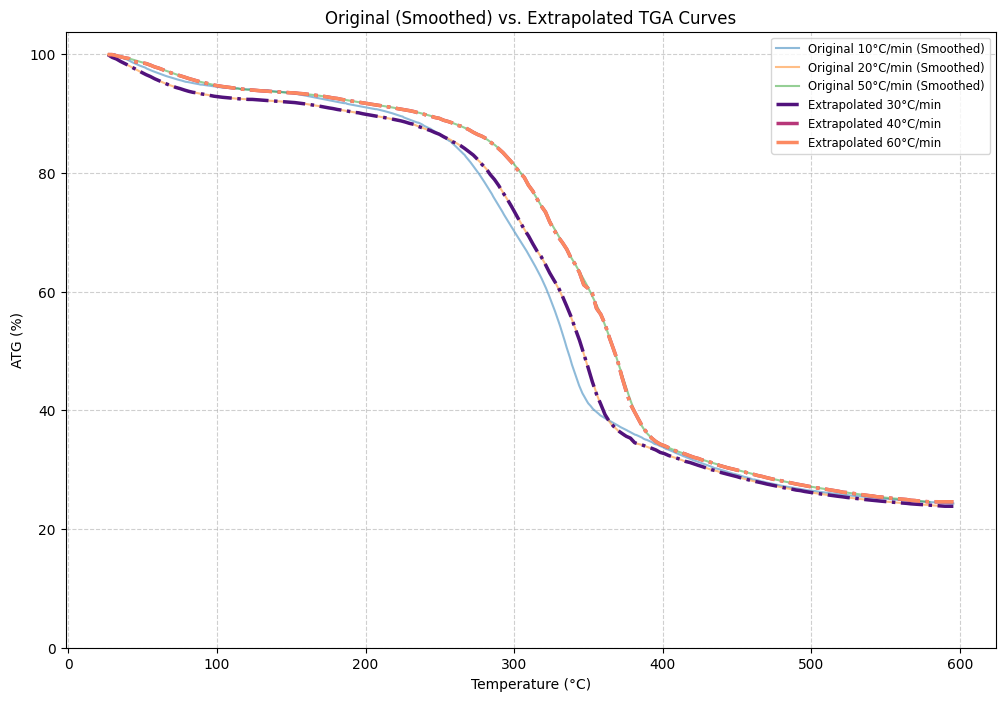


--- Generating 100 bootstrap predictions for unseen rates ---
  Completed bootstrap sample 20/100
  Completed bootstrap sample 40/100
  Completed bootstrap sample 60/100
  Completed bootstrap sample 80/100
  Completed bootstrap sample 100/100

Calculating 95% Confidence Intervals for extrapolations...

--- Visualizing Extrapolated Curves with 95% CIs ---


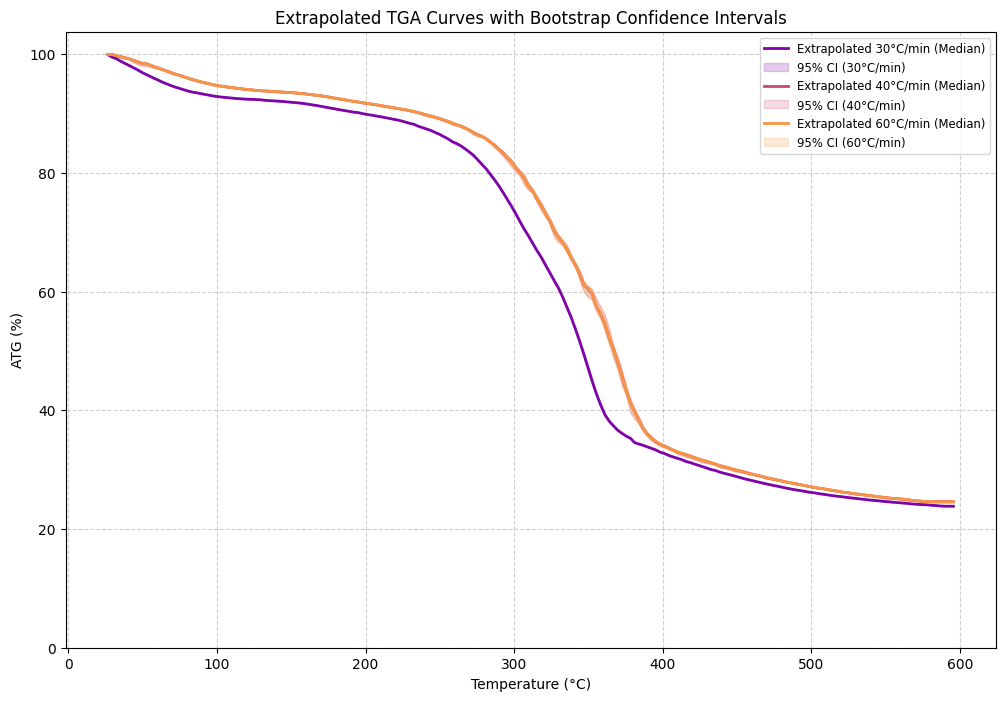


End of Phase 2 & 3: Modeling, Extrapolation & Confidence Intervals.
----------------------------------------


In [34]:
# Continue in the same script or ensure 'all_data' DataFrame is available

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression # Basic linear likely too simple for curve shape
from sklearn.svm import SVR # May work but can be slow on large data
from sklearn.preprocessing import StandardScaler # Good practice for some models
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

print("\nStarting Phase 2 & 3: Model Building, Extrapolation & Confidence Intervals")
print("----------------------------------------")

# --- Check if all_data is ready from Phase 1 ---
if 'all_data' in locals() and isinstance(all_data, pd.DataFrame) and not all_data.empty:

    # Define features (X) and target (y) based on our refined choice
    # Use the standardized column names defined in Phase 1
    temp_col = 'Temperature_C'
    target_col = 'ATG_percent'
    feature_cols = [temp_col, 'Heating_Rate'] # Inputs: Temperature and Heating Rate

    if not all(col in all_data.columns for col in feature_cols):
         print(f"\nError: Missing required feature columns {feature_cols} in the data. Cannot proceed.")
    elif target_col not in all_data.columns:
         print(f"\nError: Missing target column {target_col} in the data. Cannot proceed.")
    else:
        X = all_data[feature_cols]
        y = all_data[target_col]

        print(f"\nUsing features: {feature_cols}")
        print(f"Target variable: {target_col}")
        print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

        # --- Data Splitting ---
        # Stratify by Heating_Rate to ensure all rates are represented in train/test/val
        # Split ratio: e.g., 70% train, 15% validation, 15% test
        try:
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=X['Heating_Rate']
            )
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42, stratify=X_temp['Heating_Rate']
            )

            print(f"\nData split:")
            print(f"  Training set size:   {X_train.shape[0]}")
            print(f"  Validation set size: {X_val.shape[0]}")
            print(f"  Test set size:       {X_test.shape[0]}")

            # Check distribution of Heating Rates in splits
            print("\nHeating Rate distribution in sets:")
            print("  Train:", np.bincount(X_train['Heating_Rate'].astype(int))[::10]) # Rough check
            print("  Val:  ", np.bincount(X_val['Heating_Rate'].astype(int))[::10])
            print("  Test: ", np.bincount(X_test['Heating_Rate'].astype(int))[::10])

        except Exception as e:
             print(f"\nError during data splitting (maybe too few samples for stratification?): {e}")
             print("Attempting simple random split instead...")
             X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
             X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
             print(f"  Using simple split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")


        # --- Model Selection and Training ---
        # Tree-based models often work well for this type of task.
        # Consider scaling inputs if using models sensitive to it (like SVR, although less common here).

        # Define models (Using Pipelines for potential scaling later if needed)
        # RandomForestRegressor is a good default choice
        pipe_rf = Pipeline([
             # ('scaler', StandardScaler()), # Optional for RF
             ('rf', RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1,
                                          max_depth=20, # Limit depth slightly to prevent extreme overfitting
                                          min_samples_split=10, # Require more samples to split
                                          min_samples_leaf=5 # Require more samples per leaf
                                          ))
        ])

        # GradientBoostingRegressor is another strong option
        pipe_gbr = Pipeline([
             # ('scaler', StandardScaler()), # Optional for GBR
             ('gbr', GradientBoostingRegressor(random_state=42, n_estimators=100,
                                               learning_rate=0.1, max_depth=5)) # Common starting point
        ])


        # --- Hyperparameter Tuning (Optional but Recommended) ---
        # Example using GridSearchCV on Random Forest with the Validation set
        print("\n--- Hyperparameter Tuning (Example: Random Forest) ---")
        # Define parameter grid (adjust ranges based on initial results/data size)
        param_grid_rf = {
            'rf__n_estimators': [50, 100], # Fewer trees might be okay
            'rf__max_depth': [10, 20, None],
            'rf__min_samples_split': [10, 20],
            'rf__min_samples_leaf': [5, 10]
        }

        # Use a smaller subset for faster grid search if needed
        # X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42, stratify=X_train['Heating_Rate'])

        # Grid search using validation set implicitly (by fitting on train, scoring is implied on folds)
        # Set cv=3 or 5 for cross-validation within the training set
        grid_search_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_rf,
                                     cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

        try:
            print("Starting GridSearchCV for Random Forest...")
            grid_search_rf.fit(X_train, y_train) # Fit on the full training set
            print("Best parameters found:", grid_search_rf.best_params_)
            best_rf_model = grid_search_rf.best_estimator_

            # Evaluate the best model on the validation set
            y_pred_val_rf = best_rf_model.predict(X_val)
            rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_pred_val_rf))
            r2_val_rf = r2_score(y_val, y_pred_val_rf)
            print(f"\nBest RF Model Validation Performance: RMSE={rmse_val_rf:.4f}, R2={r2_val_rf:.4f}")

            # Train final model (potentially chosen one like RF) on Train+Validation data
            print("\n--- Training Final Model on Train+Validation Data ---")
            # Combine train and validation sets
            X_train_val = pd.concat([X_train, X_val])
            y_train_val = pd.concat([y_train, y_val])
            final_model = clone(best_rf_model) # Use the best estimator structure
            final_model.fit(X_train_val, y_train_val)
            print("Final model trained.")

            # Evaluate final model on the unseen Test set
            y_pred_test = final_model.predict(X_test)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            mae_test = mean_absolute_error(y_test, y_pred_test)
            r2_test = r2_score(y_test, y_pred_test)
            print("\n--- Final Model Performance on Test Set ---")
            print(f"RMSE: {rmse_test:.4f}")
            print(f"MAE:  {mae_test:.4f}")
            print(f"R²:   {r2_test:.4f}")

            # --- Visualize Predictions vs Actual on Test Set ---
            print("\n--- Visualizing Test Set Predictions ---")
            plt.figure(figsize=(12, 8))
            test_results = X_test.copy()
            test_results['Actual_ATG'] = y_test
            test_results['Predicted_ATG'] = y_pred_test

            # Plot curves for each heating rate in the test set
            unique_test_rates = sorted(test_results['Heating_Rate'].unique())
            palette = sns.color_palette('viridis', n_colors=len(unique_test_rates) * 2) # Different shade for pred/actual

            for i, rate in enumerate(unique_test_rates):
                rate_data = test_results[test_results['Heating_Rate'] == rate].sort_values(by=temp_col)
                plt.plot(rate_data[temp_col], rate_data['Actual_ATG'], label=f'Actual {rate}°C/min', color=palette[i*2], lw=2.5)
                plt.plot(rate_data[temp_col], rate_data['Predicted_ATG'], label=f'Predicted {rate}°C/min', color=palette[i*2+1], linestyle='--', lw=2)

            plt.title('Test Set: Actual vs. Predicted TGA Curves')
            plt.xlabel('Temperature (°C)')
            plt.ylabel('ATG (%)')
            plt.legend(fontsize='small')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()


            # --- Extrapolation to Unseen Heating Rates ---
            unseen_rates = [30, 40, 60] # Rates to predict for
            print(f"\n--- Extrapolating ATG (%) for unseen heating rates: {unseen_rates} ---")

            # Define temperature range for prediction curves
            # Use the min/max temperature observed across all original data
            temp_range = np.linspace(all_data[temp_col].min(), all_data[temp_col].max(), num=200) # 200 points for smooth curve

            X_unseen_list = []
            for rate_new in unseen_rates:
                df_rate_new = pd.DataFrame({
                    temp_col: temp_range,
                    'Heating_Rate': rate_new
                })
                X_unseen_list.append(df_rate_new)

            X_unseen = pd.concat(X_unseen_list)
            print(f"Created extrapolation input data with {len(X_unseen)} points.")

            # Predict using the final model
            predictions_unseen = final_model.predict(X_unseen[feature_cols]) # Ensure column order
            X_unseen['Predicted_ATG'] = predictions_unseen


            # --- Visualize Extrapolated Curves ---
            print("\n--- Visualizing Extrapolated TGA Curves ---")
            plt.figure(figsize=(12, 8))
            palette_unseen = sns.color_palette('magma', n_colors=len(unseen_rates))
            # Optionally plot original data means for comparison
            for i, rate in enumerate(sorted(all_data['Heating_Rate'].unique())):
                 rate_data = all_data[all_data['Heating_Rate'] == rate].sort_values(by=temp_col)
                 # Use rolling average for smoother plotting of noisy raw data
                 rate_data['ATG_smooth'] = rate_data[target_col].rolling(window=5, center=True, min_periods=1).mean()
                 plt.plot(rate_data[temp_col], rate_data['ATG_smooth'], label=f'Original {rate}°C/min (Smoothed)', alpha=0.5, lw=1.5)


            # Plot extrapolated curves
            for i, rate in enumerate(unseen_rates):
                rate_data = X_unseen[X_unseen['Heating_Rate'] == rate]
                plt.plot(rate_data[temp_col], rate_data['Predicted_ATG'], label=f'Extrapolated {rate}°C/min', color=palette_unseen[i], linestyle='-.', lw=2.5)

            plt.title('Original (Smoothed) vs. Extrapolated TGA Curves')
            plt.xlabel('Temperature (°C)')
            plt.ylabel('ATG (%)')
            plt.legend(fontsize='small')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.ylim(bottom=min(0, all_data[target_col].min() - 5)) # Adjust y-axis limits
            plt.show()


            # --- Confidence Intervals for Extrapolation (via Bootstrapping) ---
            n_bootstraps = 100 # Fewer might be okay for faster check, increase for paper (e.g., 200-500)
            print(f"\n--- Generating {n_bootstraps} bootstrap predictions for unseen rates ---")
            # We need predictions for each point in X_unseen
            bootstrap_preds_matrix = np.zeros((X_unseen.shape[0], n_bootstraps)) * np.nan

            original_indices = X_train_val.index # Use indices from combined train+val data

            for i in range(n_bootstraps):
                boot_indices = np.random.choice(original_indices, size=len(original_indices), replace=True)
                X_boot = X_train_val.loc[boot_indices]
                y_boot = y_train_val.loc[boot_indices]

                try:
                    # Clone the final model structure
                    boot_model = clone(final_model)
                     # Set random state if model allows (e.g., for RF's internal randomness)
                    if 'random_state' in boot_model.get_params():
                        boot_model.set_params(random_state=i)
                    elif isinstance(boot_model, Pipeline) and 'random_state' in boot_model.steps[-1][1].get_params():
                         final_step_name = boot_model.steps[-1][0]
                         boot_model.set_params(**{f'{final_step_name}__random_state': i})

                    boot_model.fit(X_boot, y_boot)
                    bootstrap_preds_matrix[:, i] = boot_model.predict(X_unseen[feature_cols])
                except Exception as e:
                    print(f"Warning: Bootstrap iteration {i+1} failed: {e}") # Keep NaNs

                if (i + 1) % 20 == 0: print(f"  Completed bootstrap sample {i + 1}/{n_bootstraps}")

            # Calculate CIs for unseen predictions
            print("\nCalculating 95% Confidence Intervals for extrapolations...")
            with warnings.catch_warnings(): # Suppress warnings from all-NaN slices if bootstrap failed often
                warnings.simplefilter("ignore", category=RuntimeWarning)
                lower_ci = np.nanpercentile(bootstrap_preds_matrix, 2.5, axis=1)
                upper_ci = np.nanpercentile(bootstrap_preds_matrix, 97.5, axis=1)
                median_ci = np.nanpercentile(bootstrap_preds_matrix, 50, axis=1) # Median prediction from bootstrap

            X_unseen['Pred_ATG_LowerCI'] = lower_ci
            X_unseen['Pred_ATG_UpperCI'] = upper_ci
            X_unseen['Pred_ATG_Median'] = median_ci


            # --- Visualize Extrapolated Curves with Confidence Intervals ---
            print("\n--- Visualizing Extrapolated Curves with 95% CIs ---")
            plt.figure(figsize=(12, 8))
            palette_unseen_ci = sns.color_palette('plasma', n_colors=len(unseen_rates))

            for i, rate in enumerate(unseen_rates):
                rate_data = X_unseen[X_unseen['Heating_Rate'] == rate]
                # Plot median prediction
                plt.plot(rate_data[temp_col], rate_data['Pred_ATG_Median'], color=palette_unseen_ci[i], lw=2, label=f'Extrapolated {rate}°C/min (Median)')
                # Add shaded confidence interval
                plt.fill_between(rate_data[temp_col], rate_data['Pred_ATG_LowerCI'], rate_data['Pred_ATG_UpperCI'], color=palette_unseen_ci[i], alpha=0.2, label=f'95% CI ({rate}°C/min)')

            plt.title('Extrapolated TGA Curves with Bootstrap Confidence Intervals')
            plt.xlabel('Temperature (°C)')
            plt.ylabel('ATG (%)')
            # Combine labels for clarity if too many lines
            handles, labels = plt.gca().get_legend_handles_labels()
            unique_labels = {}
            for handle, label in zip(handles, labels):
                 if "95% CI" not in label: # Keep median line labels
                      unique_labels[label] = handle
                 elif "95% CI" in label and f"95% CI ({label.split('(')[-1]}" not in unique_labels : # Keep only one CI label per rate
                      unique_labels[f"95% CI ({label.split('(')[-1]}"] = handle # Simplified label
            plt.legend(unique_labels.values(), unique_labels.keys(), fontsize='small')

            plt.grid(True, linestyle='--', alpha=0.6)
            plt.ylim(bottom=min(0, all_data[target_col].min() - 5))
            plt.show()

        except NameError as e:
            print(f"\nError: A variable needed for modeling/evaluation was not defined (likely due to errors in previous steps): {e}")
        except Exception as e:
            print(f"\nAn unexpected error occurred during modeling/evaluation: {e}")
            import traceback
            traceback.print_exc() # Print detailed traceback for debugging


else:
    print("\nModeling skipped. 'all_data' DataFrame not available or suitable from Phase 1.")

print("\nEnd of Phase 2 & 3: Modeling, Extrapolation & Confidence Intervals.")
print("----------------------------------------")

In [14]:
print("\n--- Test Set Performance by Heating Rate and Temperature Range ---")
temp_bins = np.linspace(all_data[temp_col].min(), all_data[temp_col].max(), num=6) # Example: 5 bins
test_results['Temp_Bin'] = pd.cut(test_results[temp_col], bins=temp_bins, include_lowest=True)

for rate in sorted(test_results['Heating_Rate'].unique()):
    rate_data = test_results[test_results['Heating_Rate'] == rate]
    print(f"\nHeating Rate: {rate}°C/min")
    for temp_range in rate_data['Temp_Bin'].unique():
        bin_data = rate_data[rate_data['Temp_Bin'] == temp_range]
        if not bin_data.empty:
            rmse = np.sqrt(mean_squared_error(bin_data['Actual_ATG'], bin_data['Predicted_ATG']))
            mae = mean_absolute_error(bin_data['Actual_ATG'], bin_data['Predicted_ATG'])
            r2 = r2_score(bin_data['Actual_ATG'], bin_data['Predicted_ATG'])
            print(f"  Temperature Range: {temp_range} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


--- Test Set Performance by Heating Rate and Temperature Range ---

Heating Rate: 10°C/min
  Temperature Range: (140.387, 254.179] - RMSE: 0.0140, MAE: 0.0074, R²: 1.0000
  Temperature Range: (26.593999999999998, 140.387] - RMSE: 0.0067, MAE: 0.0046, R²: 1.0000
  Temperature Range: (254.179, 367.97] - RMSE: 0.0470, MAE: 0.0347, R²: 1.0000
  Temperature Range: (367.97, 481.762] - RMSE: 0.0098, MAE: 0.0073, R²: 1.0000
  Temperature Range: (481.762, 595.554] - RMSE: 0.0038, MAE: 0.0029, R²: 1.0000

Heating Rate: 20°C/min
  Temperature Range: (481.762, 595.554] - RMSE: 0.0073, MAE: 0.0054, R²: 0.9999
  Temperature Range: (254.179, 367.97] - RMSE: 0.1036, MAE: 0.0852, R²: 1.0000
  Temperature Range: (140.387, 254.179] - RMSE: 0.0251, MAE: 0.0140, R²: 0.9998
  Temperature Range: (26.593999999999998, 140.387] - RMSE: 0.0280, MAE: 0.0157, R²: 0.9999
  Temperature Range: (367.97, 481.762] - RMSE: 0.0517, MAE: 0.0297, R²: 0.9996

Heating Rate: 50°C/min
  Temperature Range: (254.179, 367.97] - R

# Neural Network Model


--- Neural Network Model Training ---
Training the Neural Network...

Neural Network Validation Performance: RMSE=0.5543, R2=0.9997

--- Neural Network Performance on Test Set ---
RMSE: 0.5494
MAE:  0.4204
R²:   0.9997

--- Visualizing Test Set Predictions (Neural Network) ---


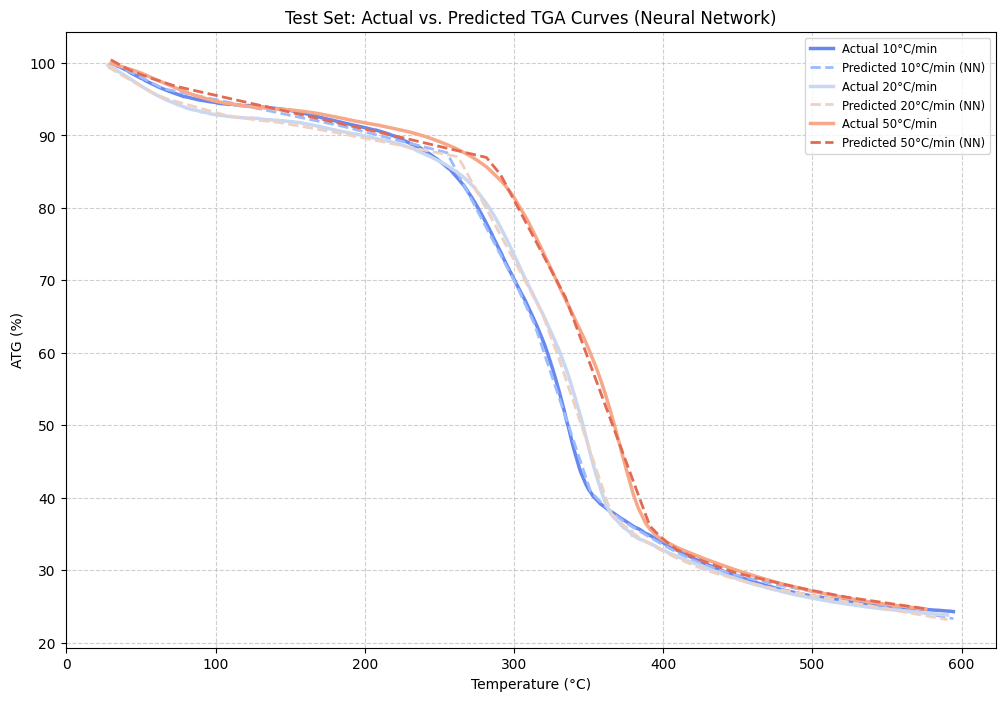

In [11]:
# --- Neural Network Model (using scikit-learn) ---
from sklearn.neural_network import MLPRegressor

print("\n--- Neural Network Model Training ---")

# Define a pipeline with scaling and the MLP regressor
pipe_nn = Pipeline([
    ('scaler', StandardScaler()), # Scaling is crucial for neural networks
    ('nn', MLPRegressor(random_state=42,
                         hidden_layer_sizes=(64, 64), # Example: two hidden layers with 64 neurons each
                         activation='relu', # Common activation function
                         solver='adam', # Optimizer
                         max_iter=300, # Number of training epochs
                         learning_rate_init=0.01, # Initial learning rate
                         early_stopping=True, # Stop if validation score doesn't improve
                         n_iter_no_change=10 # Patience for early stopping
                         ))
])

# Train the neural network model
print("Training the Neural Network...")
pipe_nn.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_val_nn = pipe_nn.predict(X_val)
rmse_val_nn = np.sqrt(mean_squared_error(y_val, y_pred_val_nn))
r2_val_nn = r2_score(y_val, y_pred_val_nn)
print(f"\nNeural Network Validation Performance: RMSE={rmse_val_nn:.4f}, R2={r2_val_nn:.4f}")

# Evaluate on the test set
y_pred_test_nn = pipe_nn.predict(X_test)
rmse_test_nn = np.sqrt(mean_squared_error(y_test, y_pred_test_nn))
mae_test_nn = mean_absolute_error(y_test, y_pred_test_nn)
r2_test_nn = r2_score(y_test, y_pred_test_nn)
print("\n--- Neural Network Performance on Test Set ---")
print(f"RMSE: {rmse_test_nn:.4f}")
print(f"MAE:  {mae_test_nn:.4f}")
print(f"R²:   {r2_test_nn:.4f}")

# Visualize predictions on the test set (optional)
print("\n--- Visualizing Test Set Predictions (Neural Network) ---")
plt.figure(figsize=(12, 8))
test_results_nn = X_test.copy()
test_results_nn['Actual_ATG'] = y_test
test_results_nn['Predicted_ATG'] = y_pred_test_nn

unique_test_rates_nn = sorted(test_results_nn['Heating_Rate'].unique())
palette_nn = sns.color_palette('coolwarm', n_colors=len(unique_test_rates_nn) * 2)

for i, rate in enumerate(unique_test_rates_nn):
    rate_data_nn = test_results_nn[test_results_nn['Heating_Rate'] == rate].sort_values(by=temp_col)
    plt.plot(rate_data_nn[temp_col], rate_data_nn['Actual_ATG'], label=f'Actual {rate}°C/min', color=palette_nn[i*2], lw=2.5)
    plt.plot(rate_data_nn[temp_col], rate_data_nn['Predicted_ATG'], label=f'Predicted {rate}°C/min (NN)', color=palette_nn[i*2+1], linestyle='--', lw=2)

plt.title('Test Set: Actual vs. Predicted TGA Curves (Neural Network)')
plt.xlabel('Temperature (°C)')
plt.ylabel('ATG (%)')
plt.legend(fontsize='small')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# All models

Loading, renaming, and combining data from sheets...

--- Processing Sheet: 10°Cmin (Heating Rate: 10°C/min) ---
  Note: Reading sheet '10°Cmin' with header from row 2 (skipping first row).
  DEBUG: Columns as read by pandas: ['t (min)', 'T (°C)', 'm  (m)g', 'ATG (%)', 'Deriv, Weight (%/min)', 'Deriv, Weight (%/°C)']
  DEBUG: Columns after stripping whitespace: ['t (min)', 'T (°C)', 'm  (m)g', 'ATG (%)', 'Deriv, Weight (%/min)', 'Deriv, Weight (%/°C)']
  DEBUG: Defined rename_map for rate 10.
  DEBUG: Actual rename map being applied: {'t (min)': 'Time_min', 'T (°C)': 'Temperature_C', 'ATG (%)': 'ATG_percent', 'Deriv, Weight (%/min)': 'DTG_percent_per_min', 'Deriv, Weight (%/°C)': 'DTG_percent_per_C'}
  Renamed columns: ['Time_min', 'Temperature_C', 'm  (m)g', 'ATG_percent', 'DTG_percent_per_min', 'DTG_percent_per_C']
  DEBUG: Attempting numeric conversion for columns: ['Temperature_C', 'ATG_percent', 'Mass_mg', 'DTG_percent_per_min', 'DTG_percent_per_C', 'Time_min']
  DEBUG: Data shape

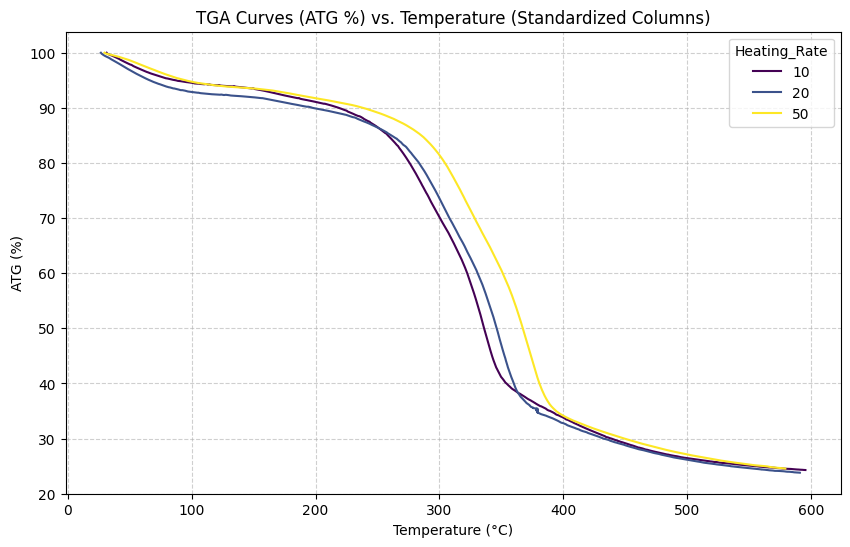


Checking distribution of data points by Heating Rate...


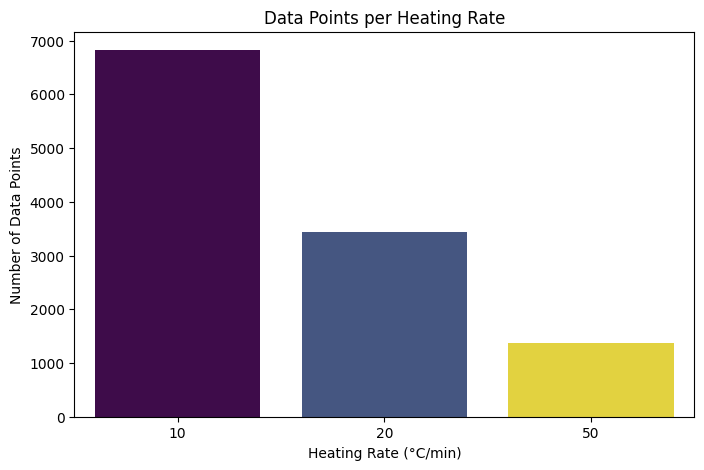


End of Phase 1: Data Loading & Preparation.
----------------------------------------

Starting Phase 2 & 3: Model Building, Extrapolation & Confidence Intervals
----------------------------------------

Using features: ['Temperature_C', 'Heating_Rate']
Target variable: ATG_percent
Shape of X: (11635, 2), Shape of y: (11635,)

--- Data Interpolation for Neural Network ---
Data interpolated for neural network training.

Data split (original data for tree models):
  Training set size:   8144
  Validation set size: 1745
  Test set size:       1746

Heating Rate distribution in sets (original data):
  Train: [   0 4777 2409    0    0  958]
  Val:   [   0 1024  516    0    0  205]
  Test:  [   0 1024  516    0    0  206]

Data split (interpolated data for NN):
  Training set size:   14332
  Validation set size: 3071
  Test set size:       3072

--- Training Tree-Based Models (Original Data) ---

--- Neural Network Model Training (Interpolated Data) ---
Training the Neural Network (Interpola

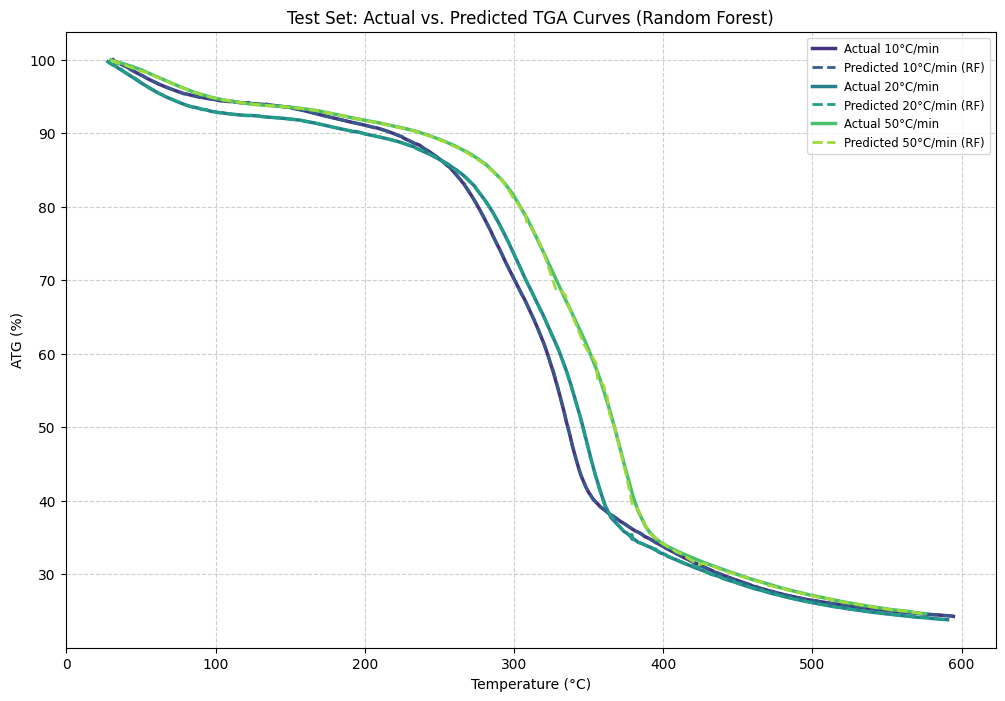


--- Visualizing Test Set Predictions (Neural Network) ---


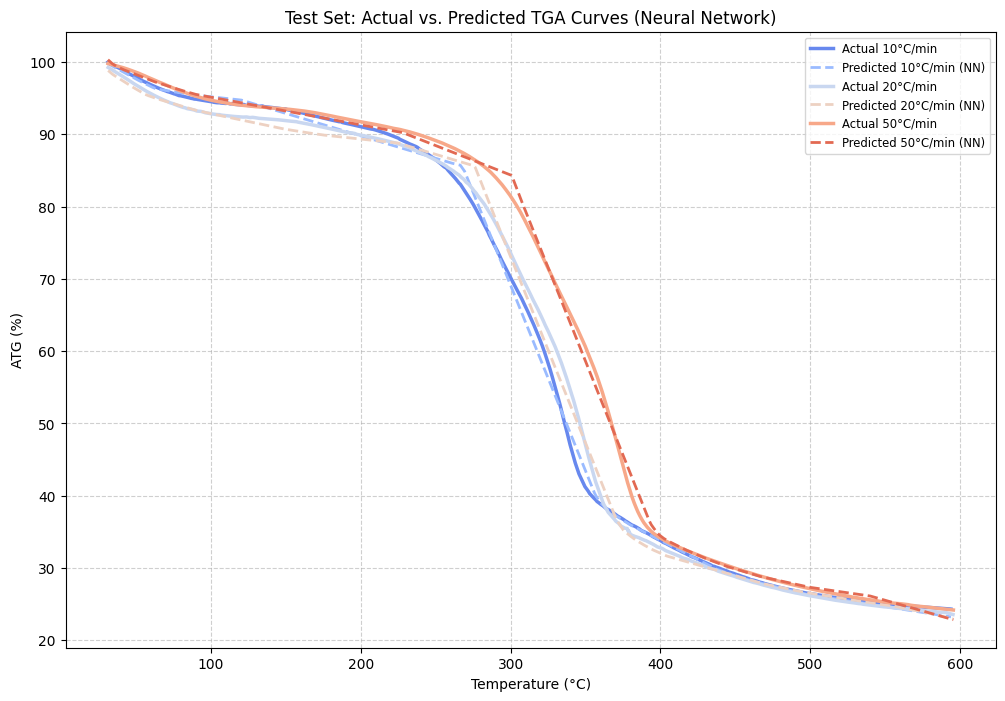


--- Extrapolating ATG (%) for unseen heating rates: [30, 40, 60] (using Random Forest) ---

--- Visualizing Extrapolated TGA Curves (Random Forest) ---


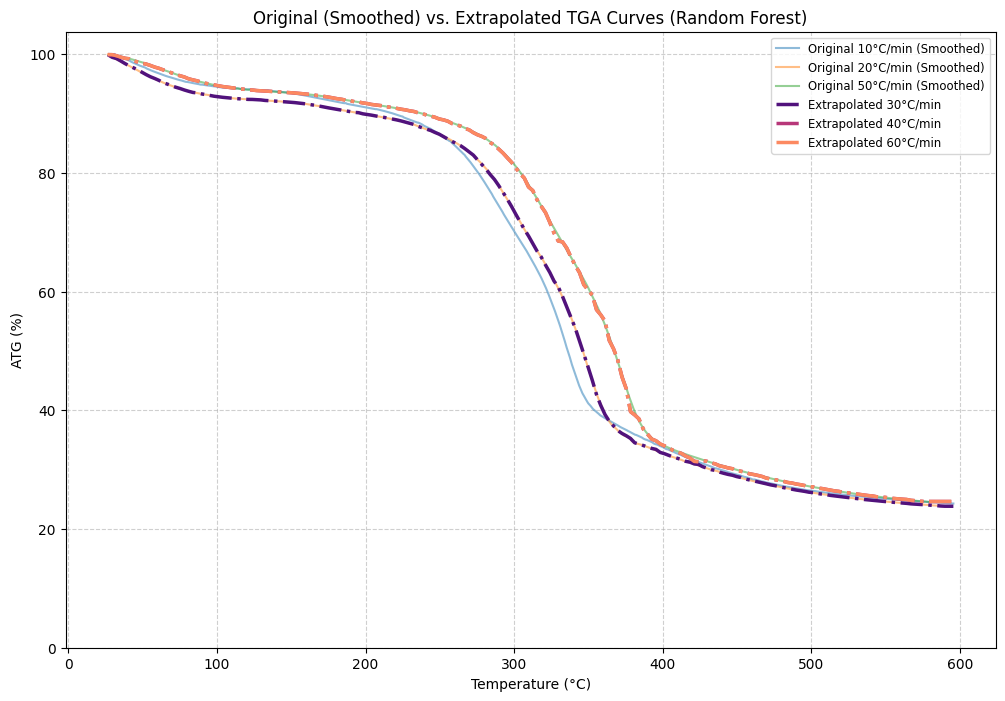


--- Generating 100 bootstrap predictions for unseen rates (Random Forest) ---
  Completed bootstrap sample 20/100
  Completed bootstrap sample 40/100
  Completed bootstrap sample 60/100
  Completed bootstrap sample 80/100
  Completed bootstrap sample 100/100

Calculating 95% Confidence Intervals for extrapolations (Random Forest)...

--- Visualizing Extrapolated Curves with 95% CIs (Random Forest) ---


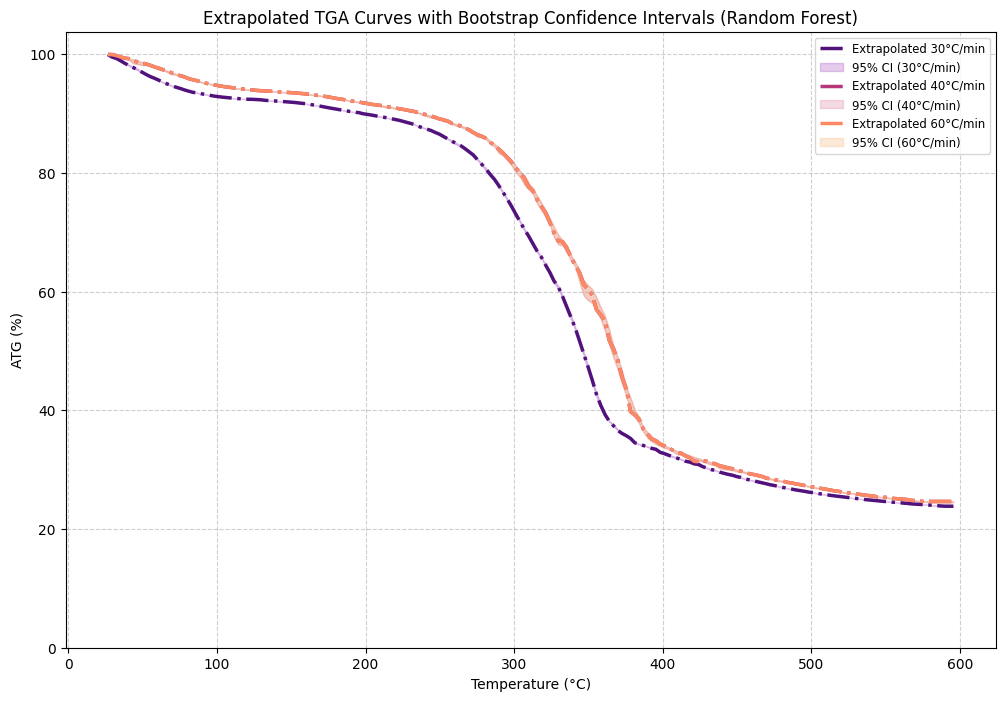


End of Phase 2 & 3: Modeling, Extrapolation & Confidence Intervals.
----------------------------------------


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone
from scipy.interpolate import interp1d

# Suppress specific warnings if needed
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, message='.*Could not infer format.*')


# !! REPLACE with the correct path to your Excel file !!
excel_file_path = '/Users/sienkadounia/Downloads/TGA- empty fruit bunch - to Hassan (1).xlsx'

# Heating rates and corresponding sheet names (VERIFY THESE)
sheet_names = {
    10: '10°Cmin',
    20: '20°Cmin',
    50: '50°Cmin'
}
heating_rates = sorted(list(sheet_names.keys()))
# Specify which rates have the header in the second row (index 1)
rates_with_header_row_2 = [10, 20, 50]

# --- Define Standardized Column Names ---
# We will rename the columns from each sheet to these standard names.
std_col_time = 'Time_min'
std_col_temp = 'Temperature_C'
std_col_mass = 'Mass_mg'
std_col_atg = 'ATG_percent' # <<< This is our TARGET variable
std_col_dtg_time = 'DTG_percent_per_min'
std_col_dtg_temp = 'DTG_percent_per_C'

# The columns we absolutely NEED for the model (using standard names)
required_std_cols = [std_col_temp, std_col_atg]
# Features we will use for modeling X = f(T, Rate) -> ATG (using standard names)
feature_std_cols = [std_col_temp, 'Heating_Rate']


# --- Data Loading, Renaming, and Combination ---

all_data_list = []
print("Loading, renaming, and combining data from sheets...")

for rate in heating_rates:
    sheet = sheet_names.get(rate)
    if not sheet:
        print(f"Warning: No sheet name defined for heating rate {rate}. Skipping.")
        continue

    print(f"\n--- Processing Sheet: {sheet} (Heating Rate: {rate}°C/min) ---")
    try:
        # --- Set header row based on heating rate ---
        header_row_index = 0 # Default: first row is header
        if rate in rates_with_header_row_2:
            header_row_index = 1 # Use second row as header for rates in rates_with_header_row_2
            print(f"  Note: Reading sheet '{sheet}' with header from row {header_row_index + 1} (skipping first row).")
        else:
            # This executes for rate == 10
            print(f"  Note: Reading sheet '{sheet}' with header from row {header_row_index + 1}.")

        # Load the raw TGA data using the determined header row
        df_raw = pd.read_excel(excel_file_path, sheet_name=sheet, header=header_row_index)
        # --- DEBUG: Print columns immediately after loading ---
        print(f"  DEBUG: Columns as read by pandas: {df_raw.columns.tolist()}")

        # Strip leading/trailing whitespace from column names robustly
        original_columns_stripped = [str(col).strip() for col in df_raw.columns]
        df_raw.columns = original_columns_stripped
        print(f"  DEBUG: Columns after stripping whitespace: {original_columns_stripped}")


        # --- Define Renaming Map based on Rate ---
        # Use the stripped column names as keys in the map definitions
        rename_map = {}
        if rate == 10:
            # Based on user input: 't (min)', 'T (°C)', 'm (mg)', 'ATG (%)', 'Deriv, Weight (%/min)', 'Deriv, Weight (%/°C)'
            # !! VERIFY THESE KEYS EXACTLY MATCH the stripped names printed above !!
            rename_map = {
                't (min)': std_col_time,
                'T (°C)': std_col_temp,
                'm (m)g': std_col_mass,          # Corrected mapping based on previous debug output
                'ATG (%)': std_col_atg,
                'Deriv, Weight (%/min)': std_col_dtg_time,
                'Deriv, Weight (%/°C)': std_col_dtg_temp
            }
            print("  DEBUG: Defined rename_map for rate 10.")

        elif rate == 20:
            # Based on user input: 't', 'T', 'mg', 'ATG (%)', 'DTG (%/min)', 'DTG (%/°C)'
            rename_map = {
                't': std_col_time,
                'T': std_col_temp,
                'mg': std_col_mass,
                'ATG (%)': std_col_atg,
                'DTG (%/min)': std_col_dtg_time,
                'DTG (%/°C)': std_col_dtg_temp
            }
            print("  DEBUG: Defined rename_map for rate 20.")

        elif rate == 50:
            # Based on user input: 'Time (min)', 'Temperature (°C)', 'Weight (mg)', 'ATG (%)', 'DTG (%/min)', 'DTG (%/°C)'
            rename_map = {
                'Time (min)': std_col_time,
                'Temperature (°C)': std_col_temp,
                'Weight (mg)': std_col_mass,
                'ATG (%)': std_col_atg,
                'DTG (%/min)': std_col_dtg_time,
                'DTG (%/°C)': std_col_dtg_temp
            }
            print("  DEBUG: Defined rename_map for rate 50.")

        # --- Apply Renaming ---
        # Create the actual map based on columns that *exist* after stripping
        rename_actual = {k: v for k, v in rename_map.items() if k in original_columns_stripped}
        # --- DEBUG: Print the rename map being used ---
        print(f"  DEBUG: Actual rename map being applied: {rename_actual}")

        df_raw.rename(columns=rename_actual, inplace=True)
        renamed_columns = df_raw.columns.tolist()
        print(f"  Renamed columns: {renamed_columns}")

        # --- Check if Required Standard Columns Exist After Renaming ---
        missing_std = [col for col in required_std_cols if col not in renamed_columns]
        if missing_std:
            print(f"  Error: Missing required standardized columns after renaming: {missing_std}. Check original column names and renaming map. Skipping sheet.")
            # --- DEBUG: Print DataFrame columns when error occurs ---
            print(f"  DEBUG: Columns present when error occurred: {renamed_columns}")
            continue # Skip this sheet

        # --- Select only the columns with standard names that we defined ---
        # Include all standardized columns that were successfully renamed/present
        available_std_cols = [
            std_col_time, std_col_temp, std_col_mass, std_col_atg,
            std_col_dtg_time, std_col_dtg_temp
        ]
        cols_to_keep = [col for col in available_std_cols if col in renamed_columns]
        df_sheet = df_raw[cols_to_keep].copy()

        # Add Heating_Rate column
        df_sheet['Heating_Rate'] = rate

        # --- Convert relevant columns to numeric ---
        # Use standard names here
        numeric_cols = [std_col_temp, std_col_atg, std_col_mass, std_col_dtg_time, std_col_dtg_temp, std_col_time]
        print(f"  DEBUG: Attempting numeric conversion for columns: {numeric_cols}")
        for col in numeric_cols:
            if col in df_sheet.columns:
                original_dtype = df_sheet[col].dtype
                df_sheet[col] = pd.to_numeric(df_sheet[col], errors='coerce')
                if df_sheet[col].isnull().any() and not pd.isna(original_dtype): # Check if NaNs were introduced
                    print(f"    Warning: Coerced non-numeric values to NaN in column '{col}'.")


        # --- Drop rows where essential columns became NaN ---
        initial_rows = len(df_sheet)
        # Use standard names here
        df_sheet.dropna(subset=required_std_cols, inplace=True)
        rows_dropped = initial_rows - len(df_sheet)
        if rows_dropped > 0:
            print(f"  Dropped {rows_dropped} rows due to NaN values in essential columns {required_std_cols} after numeric conversion.")

        if df_sheet.empty:
            print(f"  Warning: No valid data rows remain in sheet '{sheet}' after cleaning NaNs in essential columns.")
            continue

        # --- DEBUG: Print info after cleaning ---
        print(f"  DEBUG: Data shape after cleaning for rate {rate}: {df_sheet.shape}")
        # print(f"  DEBUG: Head of cleaned data for rate {rate}:\n{df_sheet.head()}") # Uncomment for more detail

        print(f"  Sheet '{sheet}' processed successfully.")
        all_data_list.append(df_sheet)

    except FileNotFoundError:
        print(f"Error: File not found at {excel_file_path}")
        break # Stop processing if file not found
    except Exception as e:
        print(f"Error processing sheet '{sheet}': {e}")
        import traceback
        traceback.print_exc() # Print full error traceback for debugging


# --- Combine data from all sheets into a single DataFrame ---
if not all_data_list:
    print("\nError: No data successfully loaded and processed from any sheet. Cannot proceed.")
    exit() # Stop script
else:
    all_data = pd.concat(all_data_list, ignore_index=True)
    print("\n----------------------------------------")
    print("Data Loading and Preparation Complete.")
    print("Combined DataFrame Info:")
    all_data.info() # Uses standard names now
    print("\nCombined DataFrame Head:\n", all_data.head())
    print("\nCombined DataFrame Description:\n", all_data.describe())
    print("\nMissing values check in final combined data:")
    print(all_data.isnull().sum())


# --- Basic EDA on Combined Data ---
# (This part remains the same as before, using standard column names like std_col_temp, std_col_atg)
if 'all_data' in locals() and not all_data.empty:
    print("\n----------------------------------------")
    print("Starting Basic Exploratory Data Analysis (EDA)...")

    # Plot ATG vs Temperature, colored by Heating Rate
    print("\nGenerating ATG vs Temperature plot...")
    try:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=all_data, x=std_col_temp, y=std_col_atg, hue='Heating_Rate', palette='viridis', legend='full')
        plt.title('TGA Curves (ATG %) vs. Temperature (Standardized Columns)')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('ATG (%)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    except Exception as e:
        print(f"Error generating ATG vs Temp plot: {e}")

    # Distribution of Heating Rates in the combined data
    print("\nChecking distribution of data points by Heating Rate...")
    try:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=all_data, x='Heating_Rate', palette='viridis', hue='Heating_Rate', legend=False)
        plt.title('Data Points per Heating Rate')
        plt.xlabel('Heating Rate (°C/min)')
        plt.ylabel('Number of Data Points')
        plt.show()
    except Exception as e:
        print(f"Error generating count plot: {e}")
else:
    print("\nSkipping EDA: 'all_data' DataFrame is not available or empty.")


print("\nEnd of Phase 1: Data Loading & Preparation.")
print("----------------------------------------")

print("\nStarting Phase 2 & 3: Model Building, Extrapolation & Confidence Intervals")
print("----------------------------------------")

# --- Check if all_data is ready from Phase 1 ---
if 'all_data' in locals() and isinstance(all_data, pd.DataFrame) and not all_data.empty:

    # Define features (X) and target (y) based on our refined choice
    temp_col = std_col_temp
    target_col = std_col_atg
    feature_cols = [temp_col, 'Heating_Rate'] # Inputs: Temperature and Heating Rate

    if not all(col in all_data.columns for col in feature_cols):
         print(f"\nError: Missing required feature columns {feature_cols} in the data. Cannot proceed.")
    elif target_col not in all_data.columns:
         print(f"\nError: Missing target column {target_col} in the data. Cannot proceed.")
    else:
        X = all_data[feature_cols]
        y = all_data[target_col]

        print(f"\nUsing features: {feature_cols}")
        print(f"Target variable: {target_col}")
        print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

        # --- Data Interpolation for Neural Network ---
        print("\n--- Data Interpolation for Neural Network ---")
        all_data_interpolated = []
        unique_rates = all_data['Heating_Rate'].unique()
        temp_range_10 = all_data[all_data['Heating_Rate'] == 10][temp_col].sort_values().unique()

        for rate in unique_rates:
            df_rate = all_data[all_data['Heating_Rate'] == rate].sort_values(temp_col)
            if rate != 10:
                interp_func = interp1d(df_rate[temp_col], df_rate[target_col], kind='linear', fill_value="extrapolate")
                atg_interp = interp_func(temp_range_10)
                df_interp = pd.DataFrame({temp_col: temp_range_10, target_col: atg_interp, 'Heating_Rate': rate})
                all_data_interpolated.append(df_interp)
            else:
                all_data_interpolated.append(df_rate)

        all_data_balanced = pd.concat(all_data_interpolated, ignore_index=True)
        print("Data interpolated for neural network training.")

        # --- Data Splitting (using original data for tree-based models, interpolated for NN) ---
        try:
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=X['Heating_Rate']
            )
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42, stratify=X_temp['Heating_Rate']
            )

            print(f"\nData split (original data for tree models):")
            print(f"  Training set size:   {X_train.shape[0]}")
            print(f"  Validation set size: {X_val.shape[0]}")
            print(f"  Test set size:       {X_test.shape[0]}")

            # Check distribution of Heating Rates in splits
            print("\nHeating Rate distribution in sets (original data):")
            print("  Train:", np.bincount(X_train['Heating_Rate'].astype(int))[::10]) # Rough check
            print("  Val:  ", np.bincount(X_val['Heating_Rate'].astype(int))[::10])
            print("  Test: ", np.bincount(X_test['Heating_Rate'].astype(int))[::10])

        except Exception as e:
             print(f"\nError during data splitting (maybe too few samples for stratification?): {e}")
             print("Attempting simple random split instead (original data)...")
             X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
             X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
             print(f"  Using simple split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

        # Split interpolated data for neural network
        X_balanced = all_data_balanced[[temp_col, 'Heating_Rate']]
        y_balanced = all_data_balanced[target_col]

        try:
            X_train_bal, X_temp_bal, y_train_bal, y_temp_bal = train_test_split(
                X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=X_balanced['Heating_Rate']
            )
            X_val_bal, X_test_bal, y_val_bal, y_test_bal = train_test_split(
                X_temp_bal, y_temp_bal, test_size=0.5, random_state=42, stratify=X_temp_bal['Heating_Rate']
            )
            print(f"\nData split (interpolated data for NN):")
            print(f"  Training set size:   {X_train_bal.shape[0]}")
            print(f"  Validation set size: {X_val_bal.shape[0]}")
            print(f"  Test set size:       {X_test_bal.shape[0]}")
        except Exception as e:
            print(f"\nError during data splitting (interpolated data): {e}")
            X_train_bal, X_temp_bal, y_train_bal, y_temp_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
            X_val_bal, X_test_bal, y_val_bal, y_test_bal = train_test_split(X_temp_bal, y_temp_bal, test_size=0.5, random_state=42)
            print(f"  Using simple split for interpolated data.")


        # --- Model Selection and Training ---
        # Tree-based models (using original data)
        pipe_rf = Pipeline([
             ('rf', RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1, max_depth=20, min_samples_split=10, min_samples_leaf=5))
        ])

        pipe_gbr = Pipeline([
             ('gbr', GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=5))
        ])

        print("\n--- Training Tree-Based Models (Original Data) ---")
        pipe_rf.fit(X_train, y_train)
        pipe_gbr.fit(X_train, y_train)

        # --- Neural Network Model (using interpolated data) ---
        print("\n--- Neural Network Model Training (Interpolated Data) ---")
        pipe_nn = Pipeline([
            ('scaler', StandardScaler()),
            ('nn', MLPRegressor(random_state=42, hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=300, learning_rate_init=0.01, early_stopping=True, n_iter_no_change=10))
        ])
        print("Training the Neural Network (Interpolated Data)...")
        pipe_nn.fit(X_train_bal, y_train_bal)

        # --- Model Evaluation ---
        print("\n--- Model Evaluation ---")

        # Evaluate Random Forest
        y_pred_rf = pipe_rf.predict(X_test)
        rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        r2_rf = r2_score(y_test, y_pred_rf)
        print(f"\nRandom Forest Test Performance: RMSE={rmse_rf:.4f}, R2={r2_rf:.4f}")

        # Evaluate Gradient Boosting
        y_pred_gbr = pipe_gbr.predict(X_test)
        rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
        r2_gbr = r2_score(y_test, y_pred_gbr)
        print(f"Gradient Boosting Test Performance: RMSE={rmse_gbr:.4f}, R2={r2_gbr:.4f}")

        # Evaluate Neural Network (using test set from interpolated data)
        y_pred_nn = pipe_nn.predict(X_test_bal)
        rmse_nn = np.sqrt(mean_squared_error(y_test_bal, y_pred_nn))
        r2_nn = r2_score(y_test_bal, y_pred_nn)
        print(f"\nNeural Network Test Performance (Interpolated Data): RMSE={rmse_nn:.4f}, R2={r2_nn:.4f}")

        # --- Visualize Predictions (Example for Random Forest) ---
        print("\n--- Visualizing Test Set Predictions (Random Forest) ---")
        plt.figure(figsize=(12, 8))
        test_results_rf = X_test.copy()
        test_results_rf['Actual_ATG'] = y_test
        test_results_rf['Predicted_ATG'] = y_pred_rf

        unique_test_rates_rf = sorted(test_results_rf['Heating_Rate'].unique())
        palette_rf = sns.color_palette('viridis', n_colors=len(unique_test_rates_rf) * 2)

        for i, rate in enumerate(unique_test_rates_rf):
            rate_data_rf = test_results_rf[test_results_rf['Heating_Rate'] == rate].sort_values(by=temp_col)
            plt.plot(rate_data_rf[temp_col], rate_data_rf['Actual_ATG'], label=f'Actual {rate}°C/min', color=palette_rf[i*2], lw=2.5)
            plt.plot(rate_data_rf[temp_col], rate_data_rf['Predicted_ATG'], label=f'Predicted {rate}°C/min (RF)', color=palette_rf[i*2+1], linestyle='--', lw=2)

        plt.title('Test Set: Actual vs. Predicted TGA Curves (Random Forest)')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('ATG (%)')
        plt.legend(fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

        # --- Visualize Predictions for Neural Network ---
        print("\n--- Visualizing Test Set Predictions (Neural Network) ---")
        plt.figure(figsize=(12, 8))
        test_results_nn = X_test_bal.copy()
        test_results_nn['Actual_ATG'] = y_test_bal
        test_results_nn['Predicted_ATG'] = pipe_nn.predict(X_test_bal)

        unique_test_rates_nn = sorted(test_results_nn['Heating_Rate'].unique())
        palette_nn = sns.color_palette('coolwarm', n_colors=len(unique_test_rates_nn) * 2)

        for i, rate in enumerate(unique_test_rates_nn):
            rate_data_nn = test_results_nn[test_results_nn['Heating_Rate'] == rate].sort_values(by=temp_col)
            plt.plot(rate_data_nn[temp_col], rate_data_nn['Actual_ATG'], label=f'Actual {rate}°C/min', color=palette_nn[i*2], lw=2.5)
            plt.plot(rate_data_nn[temp_col], rate_data_nn['Predicted_ATG'], label=f'Predicted {rate}°C/min (NN)', color=palette_nn[i*2+1], linestyle='--', lw=2)

        plt.title('Test Set: Actual vs. Predicted TGA Curves (Neural Network)')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('ATG (%)')
        plt.legend(fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


        # --- Extrapolation and Confidence Intervals (using best performing model) ---
        # This part would remain largely the same, but you might choose the best model
        # based on the evaluation metrics. For the sake of brevity, I'll keep it using
        # the Random Forest model as in the original code.

        unseen_rates = [30, 40, 60] # Rates to predict for
        print(f"\n--- Extrapolating ATG (%) for unseen heating rates: {unseen_rates} (using Random Forest) ---")

        temp_range = np.linspace(all_data[temp_col].min(), all_data[temp_col].max(), num=200)

        X_unseen_list = []
        for rate_new in unseen_rates:
            df_rate_new = pd.DataFrame({
                temp_col: temp_range,
                'Heating_Rate': rate_new
            })
            X_unseen_list.append(df_rate_new)

        X_unseen = pd.concat(X_unseen_list)
        predictions_unseen = pipe_rf.predict(X_unseen[feature_cols])
        X_unseen['Predicted_ATG'] = predictions_unseen

        print("\n--- Visualizing Extrapolated TGA Curves (Random Forest) ---")
        plt.figure(figsize=(12, 8))
        palette_unseen = sns.color_palette('magma', n_colors=len(unseen_rates))
        for i, rate in enumerate(sorted(all_data['Heating_Rate'].unique())):
             rate_data = all_data[all_data['Heating_Rate'] == rate].sort_values(by=temp_col)
             rate_data['ATG_smooth'] = rate_data[target_col].rolling(window=5, center=True, min_periods=1).mean()
             plt.plot(rate_data[temp_col], rate_data['ATG_smooth'], label=f'Original {rate}°C/min (Smoothed)', alpha=0.5, lw=1.5)

        for i, rate in enumerate(unseen_rates):
            rate_data = X_unseen[X_unseen['Heating_Rate'] == rate]
            plt.plot(rate_data[temp_col], rate_data['Predicted_ATG'], label=f'Extrapolated {rate}°C/min', color=palette_unseen[i], linestyle='-.', lw=2.5)

        plt.title('Original (Smoothed) vs. Extrapolated TGA Curves (Random Forest)')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('ATG (%)')
        plt.legend(fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.ylim(bottom=min(0, all_data[target_col].min() - 5))
        plt.show()

        n_bootstraps = 100
        print(f"\n--- Generating {n_bootstraps} bootstrap predictions for unseen rates (Random Forest) ---")
        bootstrap_preds_matrix = np.zeros((X_unseen.shape[0], n_bootstraps)) * np.nan
        X_train_val = pd.concat([X_train, X_val])
        y_train_val = pd.concat([y_train, y_val])
        original_indices = X_train_val.index

        for i in range(n_bootstraps):
            boot_indices = np.random.choice(original_indices, size=len(original_indices), replace=True)
            X_boot = X_train_val.loc[boot_indices]
            y_boot = y_train_val.loc[boot_indices]

            try:
                boot_model = clone(pipe_rf)
                if isinstance(boot_model, Pipeline) and 'random_state' in boot_model.steps[-1][1].get_params():
                     final_step_name = boot_model.steps[-1][0]
                     boot_model.set_params(**{f'{final_step_name}__random_state': i})
                elif 'random_state' in boot_model.get_params():
                    boot_model.set_params(random_state=i)
                boot_model.fit(X_boot, y_boot)
                bootstrap_preds_matrix[:, i] = boot_model.predict(X_unseen[feature_cols])
            except Exception as e:
                print(f"Warning: Bootstrap iteration {i+1} failed: {e}")

            if (i + 1) % 20 == 0: print(f"  Completed bootstrap sample {i + 1}/{n_bootstraps}")

        print("\nCalculating 95% Confidence Intervals for extrapolations (Random Forest)...")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            lower_ci = np.nanpercentile(bootstrap_preds_matrix, 2.5, axis=1)
            upper_ci = np.nanpercentile(bootstrap_preds_matrix, 97.5, axis=1)
            median_ci = np.nanpercentile(bootstrap_preds_matrix, 50, axis=1)

        X_unseen['Pred_ATG_LowerCI'] = lower_ci
        X_unseen['Pred_ATG_UpperCI'] = upper_ci
        X_unseen['Pred_ATG_Median'] = median_ci

        print("\n--- Visualizing Extrapolated Curves with 95% CIs (Random Forest) ---")
        plt.figure(figsize=(12, 8))
        palette_unseen_ci = sns.color_palette('plasma', n_colors=len(unseen_rates))

        for i, rate in enumerate(unseen_rates):
            rate_data = X_unseen[X_unseen['Heating_Rate'] == rate]
            plt.plot(rate_data[temp_col], rate_data['Predicted_ATG'], label=f'Extrapolated {rate}°C/min', color=palette_unseen[i], linestyle='-.', lw=2.5)
            plt.fill_between(rate_data[temp_col], rate_data['Pred_ATG_LowerCI'], rate_data['Pred_ATG_UpperCI'], color=palette_unseen_ci[i], alpha=0.2, label=f'95% CI ({rate}°C/min)')

        plt.title('Extrapolated TGA Curves with Bootstrap Confidence Intervals (Random Forest)')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('ATG (%)')
        handles, labels = plt.gca().get_legend_handles_labels()
        unique_labels = {}
        for handle, label in zip(handles, labels):
             if "95% CI" not in label:
                  unique_labels[label] = handle
             elif "95% CI" in label and f"95% CI ({label.split('(')[-1]}" not in unique_labels :
                  unique_labels[f"95% CI ({label.split('(')[-1]}"] = handle
        plt.legend(unique_labels.values(), unique_labels.keys(), fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.ylim(bottom=min(0, all_data[target_col].min() - 5))
        plt.show()


else:
    print("\nModeling skipped. 'all_data' DataFrame not available or suitable from Phase 1.")

print("\nEnd of Phase 2 & 3: Modeling, Extrapolation & Confidence Intervals.")
print("----------------------------------------")

In [39]:
for rate in unseen_rates:
    sample_data = X_unseen[X_unseen['Heating_Rate'] == rate].iloc[::20]  # Sample every 20th point
    print(f"Sample predictions for {rate}°C/min:")
    print(sample_data[[temp_col, 'Predicted_ATG']].head())
    print("\n")

Sample predictions for 30°C/min:
    Temperature_C  Predicted_ATG
0       26.595050      99.921715
20      83.776854      93.567174
40     140.958658      92.075715
60     198.140462      89.964160
80     255.322266      85.710377


Sample predictions for 40°C/min:
    Temperature_C  Predicted_ATG
0       26.595050      99.939020
20      83.776854      95.679947
40     140.958658      93.659096
60     198.140462      91.802164
80     255.322266      88.717970


Sample predictions for 60°C/min:
    Temperature_C  Predicted_ATG
0       26.595050      99.939020
20      83.776854      95.679947
40     140.958658      93.659096
60     198.140462      91.802164
80     255.322266      88.717970




La temperature max en fonction de la 

In [21]:
# --- Data Interpolation for Neural Network ---
print("\n--- Data Interpolation for Neural Network ---")
all_data_interpolated_list = [] # Use a new list name for clarity

if all_data.empty:
    print("Error: 'all_data' (original combined data) is empty. Cannot proceed with interpolation.")
    all_data_balanced = pd.DataFrame() # Ensure it's defined for later checks
else:
    unique_rates_in_data = sorted(all_data['Heating_Rate'].unique())
    print(f"  Unique heating rates found in all_data: {unique_rates_in_data}")

    # 1. Create a common, robust reference temperature range
    min_temp_overall = all_data[temp_col].min()
    max_temp_overall = all_data[temp_col].max()
    # Determine number of points for interpolation grid (e.g., 200 or avg length of curves)
    num_interp_points = 200
    
    reference_temp_range = np.array([]) # Initialize as empty
    if pd.notna(min_temp_overall) and pd.notna(max_temp_overall) and min_temp_overall < max_temp_overall:
        reference_temp_range = np.linspace(min_temp_overall, max_temp_overall, num_interp_points)
        print(f"  Reference temperature range for interpolation: {len(reference_temp_range)} points from {reference_temp_range.min():.2f} to {reference_temp_range.max():.2f} °C.")
    else:
        print(f"  Error: Could not establish a valid overall temperature range from all_data (min: {min_temp_overall}, max: {max_temp_overall}). Skipping interpolation.")

    if len(reference_temp_range) > 0: # Proceed only if reference range is valid
        for rate in unique_rates_in_data:
            print(f"    Processing interpolation for rate: {rate}°C/min")
            df_rate_original = all_data[all_data['Heating_Rate'] == rate].sort_values(by=temp_col).copy()
            
            if df_rate_original.empty:
                print(f"      Warning: No original data found for heating rate {rate}. Skipping interpolation for this rate.")
                continue
            
            # Prepare data for interpolation: remove NaNs and duplicates in T and ATG
            df_rate_clean = df_rate_original.dropna(subset=[temp_col, target_col])
            df_rate_clean = df_rate_clean.drop_duplicates(subset=[temp_col], keep='first') # Ensure unique, sorted temperatures
            
            if len(df_rate_clean) < 2: # interp1d requires at least 2 points
                print(f"      Warning: Not enough valid data points ({len(df_rate_clean)}) for rate {rate} after cleaning. Skipping interpolation for this rate.")
                continue

            try:
                # Create interpolation function for the current rate
                interp_func = interp1d(
                    df_rate_clean[temp_col],        # x values (original temperatures for this rate)
                    df_rate_clean[target_col],       # y values (original ATG for this rate)
                    kind='linear',                  # Type of interpolation
                    fill_value="extrapolate",       # How to handle points outside original range
                    bounds_error=False              # Don't raise error if extrapolating
                )
                
                # Interpolate ATG values onto the common reference_temp_range
                atg_interp = interp_func(reference_temp_range)
                
                df_interp = pd.DataFrame({
                    temp_col: reference_temp_range,
                    target_col: atg_interp,
                    'Heating_Rate': rate
                })
                all_data_interpolated_list.append(df_interp)
                print(f"      Successfully interpolated data for rate {rate}. Shape of interpolated data: {df_interp.shape}")
            
            except ValueError as ve:
                print(f"      Error during interpolation setup for rate {rate} (likely issues with input x, y for interp1d): {ve}. Skipping.")
            except Exception as e_interp:
                print(f"      Unexpected error during interpolation for rate {rate}: {e_interp}. Skipping.")
    
    # Combine all interpolated dataframes
    if not all_data_interpolated_list:
        print("Error: 'all_data_interpolated_list' is empty. This means no data was successfully interpolated for any rate. Neural Network data will be empty.")
        all_data_balanced = pd.DataFrame()
    else:
        all_data_balanced = pd.concat(all_data_interpolated_list, ignore_index=True)
        print("\nData interpolation for neural network training complete.")
        print(f"Shape of all_data_balanced: {all_data_balanced.shape}")
        if all_data_balanced.isnull().values.any():
            print("Warning: NaNs found in all_data_balanced. Check interpolation results.")
            print(all_data_balanced[all_data_balanced.isnull().any(axis=1)])


# --- Data Splitting (using original data for tree-based models, interpolated for NN) ---
# ... (your existing splitting logic for X_train, X_val, X_test, y_train, y_val, y_test from original 'all_data') ...
# This part seemed fine based on your output:
try:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=X['Heating_Rate']
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=X_temp['Heating_Rate']
    )
    print(f"\nData split (original data for tree models):") # This part was successful
    print(f"  Training set size:   {X_train.shape[0]}")
    # ... (rest of prints for original data split) ...
except Exception as e_orig_split:
    print(f"\nError during original data splitting: {e_orig_split}")
    # Fallback for original data if needed, or exit
    X_train, X_val, X_test, y_train, y_val, y_test = [None]*6


# Split interpolated data for neural network
if all_data_balanced.empty or len(all_data_balanced) < 2 : # Check if balanced data is usable for splitting
    print("\nError: 'all_data_balanced' is empty or has too few samples. Cannot split data for Neural Network.")
    X_train_bal, X_val_bal, X_test_bal, y_train_bal, y_val_bal, y_test_bal = [None]*6
    pipe_nn = None # Mark NN as unusable
else:
    X_balanced = all_data_balanced[[temp_col, 'Heating_Rate']]
    y_balanced = all_data_balanced[target_col]

    try:
        print(f"\nAttempting to split interpolated data (Shape: {X_balanced.shape})...")
        unique_rates_balanced = X_balanced['Heating_Rate'].value_counts()
        print(f"Value counts of Heating_Rate in X_balanced before split:\n{unique_rates_balanced}")
        
        # Check if any class has fewer than 2 samples for stratification
        if any(count < 2 for count in unique_rates_balanced):
            print("Warning: Some heating rates in interpolated data have fewer than 2 samples. Stratification might fail. Attempting simple split if needed.")
        
        X_train_bal, X_temp_bal, y_train_bal, y_temp_bal = train_test_split(
            X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=X_balanced['Heating_Rate']
        )
        X_val_bal, X_test_bal, y_val_bal, y_test_bal = train_test_split(
            X_temp_bal, y_temp_bal, test_size=0.5, random_state=42, stratify=X_temp_bal['Heating_Rate']
        )
        print(f"\nData split (interpolated data for NN):")
        print(f"  Training set size:   {X_train_bal.shape[0]}")
        print(f"  Validation set size: {X_val_bal.shape[0]}")
        print(f"  Test set size:       {X_test_bal.shape[0]}")
    except ValueError as e_bal_split:
        print(f"\nError during stratified splitting of interpolated data: {e_bal_split}")
        print("Attempting simple random split for interpolated data...")
        try:
            X_train_bal, X_temp_bal, y_train_bal, y_temp_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
            X_val_bal, X_test_bal, y_val_bal, y_test_bal = train_test_split(X_temp_bal, y_temp_bal, test_size=0.5, random_state=42)
            print(f"  Using simple split for interpolated data: Train={len(X_train_bal)}, Val={len(X_val_bal)}, Test={len(X_test_bal)}")
        except Exception as e_simple_split:
            print(f"  Error during simple random split of interpolated data: {e_simple_split}")
            X_train_bal, X_val_bal, X_test_bal, y_train_bal, y_val_bal, y_test_bal = [None]*6 # Nullify
            pipe_nn = None
    except Exception as e_generic_split:
        print(f"\nGeneric error during splitting of interpolated data: {e_generic_split}")
        X_train_bal, X_val_bal, X_test_bal, y_train_bal, y_val_bal, y_test_bal = [None]*6
        pipe_nn = None


--- Data Interpolation for Neural Network ---
  Unique heating rates found in all_data: [20, 50]
  Reference temperature range for interpolation: 200 points from 26.60 to 591.04 °C.
    Processing interpolation for rate: 20°C/min
      Successfully interpolated data for rate 20. Shape of interpolated data: (200, 3)
    Processing interpolation for rate: 50°C/min
      Successfully interpolated data for rate 50. Shape of interpolated data: (200, 3)

Data interpolation for neural network training complete.
Shape of all_data_balanced: (400, 3)

Data split (original data for tree models):
  Training set size:   3367

Attempting to split interpolated data (Shape: (400, 2))...
Value counts of Heating_Rate in X_balanced before split:
Heating_Rate
20    200
50    200
Name: count, dtype: int64

Data split (interpolated data for NN):
  Training set size:   280
  Validation set size: 60
  Test set size:       60



--- DTG Calculation Complete ---
   Temperature_C  Heating_Rate  DTG_predicted
0      29.454140            30       0.125712
1      32.313230            30       0.126185
2      35.172321            30       0.120547
3      38.031411            30       0.136958
4      40.890501            30       0.129780

--- Visualizing Predicted DTG Curves ---


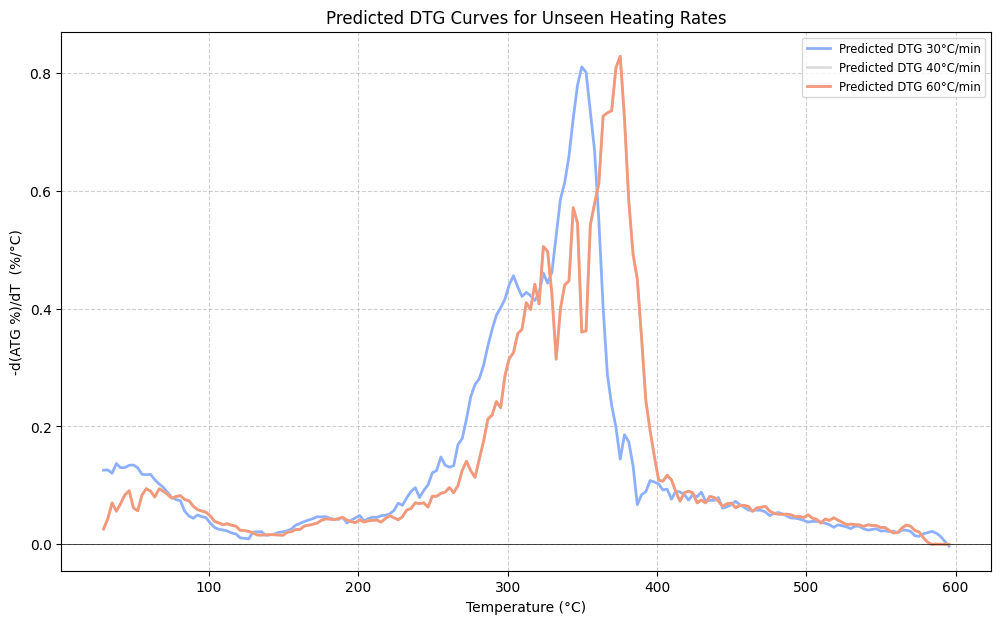

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter # For smoothing

# Assume 'X_unseen' DataFrame exists and contains:
# 'Temperature_C', 'Heating_Rate', 'Predicted_ATG' (or 'Pred_ATG_Median' if using bootstrap median)
# Make sure to use the relevant predicted ATG column.
# For example, if you used bootstrap median for plotting ATG, use that for DTG too.
predicted_atg_column_name = 'Pred_ATG_Median' # Or 'Predicted_ATG' if not using bootstrap median for this

# Ensure the DataFrame for DTG calculation has the necessary columns.
if predicted_atg_column_name not in X_unseen.columns:
    if 'Predicted_ATG' in X_unseen.columns:
        predicted_atg_column_name = 'Predicted_ATG'
        print(f"Using '{predicted_atg_column_name}' for DTG calculation.")
    else:
        print(f"Error: Neither '{predicted_atg_column_name}' nor 'Predicted_ATG' found in X_unseen columns.")
        # Handle error appropriately, e.g., exit or raise exception

# --- Calculate DTG from Predicted TGA Curves ---
dtg_results_list = []

# Use the unseen_rates list defined in your previous code
# unseen_rates = [30, 40, 60] # Make sure this is defined

if 'unseen_rates' not in locals() or not unseen_rates:
    unseen_rates = sorted(X_unseen['Heating_Rate'].unique())
    print(f"Warning: 'unseen_rates' not defined, inferring from X_unseen: {unseen_rates}")


for rate in unseen_rates:
    # Get the predicted TGA data for the current heating rate
    rate_data = X_unseen[X_unseen['Heating_Rate'] == rate].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Ensure data is sorted by temperature
    rate_data.sort_values(by='Temperature_C', inplace=True)

    if rate_data.empty:
        print(f"No data for rate {rate} to calculate DTG.")
        continue

    # Predicted ATG values for this curve
    atg_predicted = rate_data[predicted_atg_column_name].values
    temperatures = rate_data['Temperature_C'].values

    # Optional: Smooth the predicted ATG data before differentiation
    # Adjust window_length and polyorder as needed. Window length must be odd.
    # Ensure window_length < number of data points for the curve
    if len(atg_predicted) > 5 : # Only apply if enough points
        try:
            atg_predicted_smooth = savgol_filter(atg_predicted, window_length=5, polyorder=2) # Example parameters
        except ValueError:
            print(f"  Warning: Could not apply Savitzky-Golay filter for rate {rate} (possibly too few points or inappropriate window). Using original predicted ATG.")
            atg_predicted_smooth = atg_predicted # Fallback to original if smoothing fails
    else:
        atg_predicted_smooth = atg_predicted # Not enough points to smooth


    # Calculate differences (finite difference method)
    # delta_atg will be mostly negative (mass loss)
    delta_atg = np.diff(atg_predicted_smooth)
    delta_temp = np.diff(temperatures)

    # Calculate DTG (%/°C)
    # Avoid division by zero if temperature points are identical (should not happen if sorted and distinct)
    dtg_values = np.where(delta_temp == 0, 0, delta_atg / delta_temp)

    # Often DTG is plotted as -d(ATG)/dT to have positive peaks
    dtg_values_positive = -dtg_values

    # The DTG values correspond to the temperatures at the midpoint of each interval,
    # or more simply, assign to the T_i+1 point.
    # We'll have one less DTG point than original points.
    # Assign DTG to the temperatures starting from the second point.
    dtg_temperatures = temperatures[1:]

    # Create a DataFrame for this rate's DTG
    df_dtg_rate = pd.DataFrame({
        'Temperature_C': dtg_temperatures,
        'Heating_Rate': rate,
        'DTG_predicted': dtg_values_positive # Storing the positive version for typical plotting
    })
    dtg_results_list.append(df_dtg_rate)

# Combine all DTG results
if dtg_results_list:
    all_dtg_predictions = pd.concat(dtg_results_list, ignore_index=True)
    print("\n--- DTG Calculation Complete ---")
    print(all_dtg_predictions.head())

    # --- Visualize Predicted DTG Curves ---
    print("\n--- Visualizing Predicted DTG Curves ---")
    plt.figure(figsize=(12, 7))
    palette_dtg = sns.color_palette('coolwarm', n_colors=len(unseen_rates))

    for i, rate in enumerate(unseen_rates):
        rate_dtg_data = all_dtg_predictions[all_dtg_predictions['Heating_Rate'] == rate]
        if not rate_dtg_data.empty:
            plt.plot(rate_dtg_data['Temperature_C'], rate_dtg_data['DTG_predicted'],
                     label=f'Predicted DTG {rate}°C/min', color=palette_dtg[i], lw=2)

    plt.title('Predicted DTG Curves for Unseen Heating Rates')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('-d(ATG %)/dT  (%/°C)') # Label for positive peaks
    plt.legend(fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5) # Zero line
    plt.show()

else:
    print("\nNo DTG data generated.")